# Recent_adaptation_Malombe_manuscript_code — ARCHIVAL COPY

**Purpose:** Reproduces analyses and figures used in the manuscript  
*“Recent selection in heavily fished Malawi cichlids”* (Hooft van Huysduynen et al., 2025).

**Figures/Tables included:**
- Figure 2A – Population neutrality statistics (Tajima’s D & Fay & Wu’s H)
- Figure 2E – Q–Q H-statistic Malombe–Malawi
- Figure 2F – Q–Q PBS Malombe–Malawi
- Figure 3A – FCS scan and zoom plots
- Figure 3C – FCS scan and zoom plots
- Figure 4 – Variant effects and gene overlaps (UpSet)
- Supplementary – Enrichment permutation table
- Supplementary Tables S1–S2|

## Data prep

In [ ]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import os, gzip
import numpy as np
from numpy import genfromtxt
import math 
import seaborn as sns

import subprocess
jn = os.path.join


In [11]:
root_dir = "/scratch/antwerpen/grp/asvardal/projects/cichlid/"
ana_dir = '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex'

### Metadata for mloto/virginalis samples

In [12]:
def get_sample_names(subset_id):
    if subset_id == 'all_samples':
        ids = [id for id in sample_mt.index.values]
    elif subset_id == 'mloto_A':
        ids = [id for id in sample_mt[sample_mt['clade']=='mloto_A'].index.values]
    elif subset_id == 'mloto_B':
        ids = [id for id in sample_mt[sample_mt['clade']=='mloto_B'].index.values]
    elif subset_id == 'mloto_C':
        ids = [id for id in sample_mt[sample_mt['clade']=='mloto_C'].index.values]
    elif subset_id == 'virginalis':
        ids = [id for id in sample_mt[sample_mt['clade']=='virginalis'].index.values]
    elif subset_id == 'admixed':
        ids = [id for id in sample_mt[sample_mt['clade']=='admixed'].index.values]
    elif subset_id == 'Lake_Malombe_mloto_A':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Lake_Malombe_mloto_A'].index.values]
    elif subset_id == 'Monkey_Bay_Chenga_trawler_mloto_B':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Monkey_Bay_Chenga_trawler_mloto_B'].index.values]
    elif subset_id == 'Msaka_mloto_C':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Msaka_mloto_C'].index.values]
    elif subset_id == 'Namiasi_Palm_Beach_mloto_B':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Namiasi_Palm_Beach_mloto_B'].index.values]
    elif subset_id == 'Nkhata_Bay_virginalis':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Nkhata_Bay_virginalis'].index.values]
    elif subset_id == 'Nkhudzi_Bay_mloto_A':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Nkhudzi_Bay_mloto_A'].index.values]
    elif subset_id == 'Nkhata_Bay_mloto_B':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Nkhata_Bay_mloto_B'].index.values]
    elif subset_id == 'Msaka_admixed':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Msaka_admixed'].index.values] 
    elif subset_id == 'Makanjila_mloto_C':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Makanjila_mloto_C'].index.values] 
    elif subset_id == 'Chilumba_mloto_C':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Chilumba_mloto_C'].index.values] 
    elif subset_id == 'Mbenji_Islands_mloto_C':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Mbenji_Islands_mloto_C'].index.values]
    elif subset_id == 'Namiasi_Palm_Beach_mloto_A':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Namiasi_Palm_Beach_mloto_A'].index.values] 
    elif subset_id == 'Nankhwali_trawler_mloto_C':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Nankhwali_trawler_mloto_C'].index.values] 
    elif subset_id == 'Nkhotakota_mloto_A':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Nkhotakota_mloto_A'].index.values] 
    elif subset_id == 'Senga_Bay_mloto_B':
        ids = [id for id in sample_mt[sample_mt['dsuite_population']=='Senga_Bay_mloto_B'].index.values]   
    else:
        pass
    
    return(ids)  

In [13]:
###samples

sample_mt_fn = f"{ana_dir}/metadata/VirginalisMloto_FIE_mt_2023-06-09.tsv"

sample_mt = pd.read_csv(sample_mt_fn, dtype=str, sep='\t', index_col=0)#.set_index("sequence_id", drop=False)
sample_mt.drop(sample_mt[sample_mt["exclude"].notnull()].index.values, inplace = True)

#### Supplementary Table S1 – Population statistics

In [14]:
Supplementary_table_S1 = sample_mt.drop('ancestral')[['genus','species','sex','seq_depth','clade','collection_period','dsuite_population','location_pub']]

In [15]:
from Bio import Entrez
import pandas as pd
import time
import xml.etree.ElementTree as ET
from urllib.error import HTTPError
import re

Entrez.email = "alex.hooft@gmail.com"  # required by NCBI

def esearch_first_id(query: str):
    """Return first BioSample internal ID for a query string, or None."""
    try:
        with Entrez.esearch(db="biosample", term=query, retmax=1) as h:
            rec = Entrez.read(h)  # esearch has a DTD; safe to parse
        return rec["IdList"][0] if rec["IdList"] else None
    except Exception as e:
        print(f"esearch error for {query}: {e}")
        return None

def parse_biosample_and_bioproject(xml_bytes: bytes):
    """Parse BioSample XML and extract BioSample + BioProject accessions."""
    # Defaults
    biosample_acc = None
    bioproject_acc = None

    # Best-effort XML parse (BioSample XML often lacks a DTD)
    try:
        root = ET.fromstring(xml_bytes)
    except ET.ParseError:
        root = None

    # Helper: choose BioSample node if present
    bs = None
    if root is not None:
        if root.tag.endswith("BioSample"):
            bs = root
        else:
            bs = root.find(".//BioSample")

        # ---- BioSample accession (attribute on the BioSample element) ----
        if bs is not None:
            biosample_acc = bs.attrib.get("accession", biosample_acc)

        # ---- BioProject accession: try several patterns ----
        search_base = bs if bs is not None else root
        if search_base is not None:
            # 1) <Ids><Id db="BioProject">PRJNA...</Id>
            node = search_base.find(".//Id[@db='BioProject']")
            if node is not None and node.text:
                bioproject_acc = node.text.strip()

            # 2) <Links><Link db="BioProject">PRJNA...</Link> or label attr
            if not bioproject_acc:
                node = search_base.find(".//Link[@db='BioProject']") or \
                       search_base.find(".//Link[@label='BioProject']")
                if node is not None and node.text:
                    bioproject_acc = node.text.strip()

            # 3) Any element with db="BioProject" (text or accession/id attr)
            if not bioproject_acc:
                node = search_base.find(".//*[@db='BioProject']")
                if node is not None:
                    bioproject_acc = (node.text or "").strip() or \
                                     node.attrib.get("accession") or \
                                     node.attrib.get("id")

    # 4) Regex fallback on raw XML for PRJNA/PRJEB/PRJDB/PRJDA
    if not bioproject_acc:
        text = xml_bytes.decode("utf-8", errors="ignore")
        m = re.search(r"\bPRJ(?:NA|EB|DB|DA)\d+\b", text)
        if m:
            bioproject_acc = m.group(0)

    return biosample_acc, bioproject_acc

def fetch_biosample_and_bioproject_by_id(biosample_id: str):
    """Fetch BioSample XML and extract accessions (robust)."""
    try:
        with Entrez.efetch(db="biosample", id=biosample_id, retmode="xml") as h:
            xml_bytes = h.read()
        return parse_biosample_and_bioproject(xml_bytes)
    except HTTPError as e:
        print(f"HTTP error for BioSample ID {biosample_id}: {e}")
        return None, None
    except Exception as e:
        print(f"efetch error for BioSample ID {biosample_id}: {e}")
        return None, None

def fetch_from_query(query: str, pause=0.35):
    """Search by query (index value) -> return (BioSampleAcc, BioProjectAcc)."""
    bs_id = esearch_first_id(query)
    if not bs_id:
        time.sleep(pause)
        return None, None
    biosample_acc, bioproject_acc = fetch_biosample_and_bioproject_by_id(bs_id)
    time.sleep(pause)  # respect NCBI rate limits
    return biosample_acc, bioproject_acc
    print(bioproject_acc)

In [16]:
results = Supplementary_table_S1.index.to_series().apply(fetch_from_query)
Supplementary_table_S1["biosample_accession"] = results.apply(lambda x: x[0])
# Supplementary_table_S1["bioproject_accession"] = results.apply(lambda x: x[1])

In [ ]:
Supplementary_table_S1.to_csv(f"{ana_dir}/metadata/Supplementary_table_S1_mss.csv", index=True)

### Metadata for blumer et al data

In [ ]:
meta_inversion_mss_fn = f"{ana_dir}/metadata/Inversion_Table_S1.tsv"

meta_inversion = pd.read_csv(meta_inversion_mss_fn, dtype=str, sep='\t', index_col=0)#.set_index("sequence_id", drop=False)

In [ ]:
pop_sizes = meta_inversion.groupby(['species', 'location']).size()
Inv_pops = pop_sizes[pop_sizes > 4].index.tolist()

#### Supplementary Table S2 - Metadata from blumer et al.

In [ ]:
Inv_pops_set = set(Inv_pops)

# Subset the dataframe
Supplementary_table_S2_mss = meta_inversion[meta_inversion[['species', 'location']].apply(tuple, axis=1).isin(Inv_pops_set)]
Supplementary_table_S2_mss = Supplementary_table_S2_mss.drop("specimen_id", axis = 1)
Supplementary_table_S2_mss = Supplementary_table_S2_mss[Supplementary_table_S2_mss['species'] != 'mloto']
Supplementary_table_S2_mss = Supplementary_table_S2_mss.sort_values(['genus','species'])

In [ ]:
Supplementary_table_S2_mss.to_csv(f"{ana_dir}/metadata/Supplementary_table_S2_mss_2.csv", index=True)

# Results

## Population-level neutrality statistics (Tajima’s D & Fay & Wu’s H)¶

In [ ]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import os, gzip
import numpy as np
from numpy import genfromtxt
import math 
import seaborn as sns

import subprocess
jn = os.path.join

output_dir = f'{ana_dir}/output/SFS'
sfs_dir = f'{ana_dir}/analyses/SFS'

# GWAS_vcf_dir = f'{root_dir}/fAstCal1.2/GWAS1465/no_if.sf_stringent1/phased'
inv_vcf_dir = f'{root_dir}/analyses/Inversion_finder_Jaysmita/vcfs/malawi_cichlids_v3_phase/'

out_dir = f'{ana_dir}/output/genome_stats'

CHROMOSOMES = [f'chr{i}' for i in range(1,24) if i!= 21]

populations_VM = [
'Lake_Malombe_mloto_A',
'Nkhudzi_Bay_mloto_A',
'Msaka_mloto_C',
'Namiasi_Palm_Beach_mloto_B',
'Monkey_Bay_Chenga_trawler_mloto_B',
'Nkhata_Bay_mloto_B',
'Makanjila_mloto_C',
'Nkhotakota_mloto_A',
'Chilumba_mloto_C',
'Mbenji_Islands_mloto_C',
'Senga_Bay_mloto_B',
'Namiasi_Palm_Beach_mloto_A',
'Nankhwali_trawler_mloto_C',
'Nkhata_Bay_virginalis']

In [ ]:
Populations_Inv = ['Alticorpus_geoffreyi:Cape_Maclear',
 'Alticorpus_peterdaviesi:Cape_Maclear',
 'Astatotilapia_calliptera:Lake_Kingiri',
 'Astatotilapia_calliptera:Lake_Malombe',
 'Aulonocara_blue-orange:Chilumba',
 'Aulonocara_malembo-orange:Southwest_arm',
 'Aulonocara_minutus:Monkey_Bay',
 'Aulonocara_saulosi:Chiofu',
 'Aulonocara_stuartgranti:Usisya',
 'Chilotilapia_rhoadesii:Southeast_arm',
 'Chilotilapia_rhoadesii:Southwest_arm',
 'Copadichromis_chrysonotus:Lake_Malombe',
 'Copadichromis_mloto:Lake_Malombe',
 'Copadichromis_mloto:Makanjila',
 'Copadichromis_mloto:Southeast_arm',
 'Copadichromis_mloto:Southwest_arm',
 'Copadichromis_virginalis:Nkhata_Bay',
 'Cynotilapia_zebroides:Cape_Maclear',
 'Cynotilapia_zebroides:Chiofu',
 'Diplotaxodon_bigeye-black-dorsal:Chilumba',
 'Diplotaxodon_limnothrissa:Southwest_arm',
 'Diplotaxodon_macrops:Cape_Maclear',
 'Fossorochromis_rostratus:Chiofu',
 'Fossorochromis_rostratus:Lake_Malombe',
 'Fossorochromis_rostratus:Southeast_arm',
 'Labeotropheus_fuelleborni:Chilumba',
 'Labeotropheus_trewavasae:Chilumba',
 'Lethrinops_gossei:Cape_Maclear',
 'Lethrinops_gossei:Monkey_Bay',
 'Lethrinops_lethrinus:Southeast_arm',
 'Maylandia_callainos:Chilumba',
 'Maylandia_emmiltos:Chilumba',
 'Maylandia_fainzilberi:Chilumba',
 'Maylandia_ngarae:Chilumba',
 'Maylandia_pearly:Chilumba',
 'Maylandia_zebra:Cape_Maclear',
 'Maylandia_zebra:Chiofu',
 'Maylandia_zebra:Nkhata_Bay',
 'Melanochromis_auratus:Senga_Bay',
 'Mylochromis_subocularis:Southeast_arm',
 'Otopharynx_argyrosoma:Lake_Malombe',
 'Otopharynx_argyrosoma:Southeast_arm',
 'Petrotilapia_genalutea:Chiofu',
 'Petrotilapia_genalutea-northern:Chilumba',
 'Petrotilapia_microgalana:Nkhata_Bay',
 'Placidochromis_longimanus:Chia_Lagoon',
 'Protomelas_ornatus:Chiofu',
 'Rhamphochromis_ferox:Makanjila',
 'Rhamphochromis_greyback:Nkhata_Bay',
 'Sciaenochromis_benthicola:Monkey_Bay',
 'Trematocranus_placodon:Chiofu',
 'Trematocranus_placodon:Southeast_arm',
 'Trematocranus_placodon:Southwest_arm',
 'Tropheops_band:Nkhata_Bay',
 'Tropheops_chilumba:Chilumba',
 'Tropheops_chiofu-yellow:Chiofu',
 'Tropheops_gracilior:Nkhata_Bay',
 'Tropheops_orange-head:Chilumba',
 'Tropheops_rust:Nkhata_Bay',
 'Tropheops_yellow-gular:Chiofu']

In [ ]:
def read_stats_data2(subset_id):
    TD_wg = []
    for chrom in CHROMOSOMES:
        out_pre = jn(out_dir,f"{subset_id}.{chrom}")
        td_fn = jn(out_pre + ".Tajima.D")
        TD = pd.read_csv(td_fn, sep='\t', index_col=[0,1])
        TD_wg.append(TD)
    TD_wg = pd.concat(TD_wg, axis=0)
    
    TD_wg = TD_wg[TD_wg['N_SNPS']>25]
    return(TD_wg)

def collect_stats_data2(population_list,column, multiindex):
    all_pop_df = pd.DataFrame(columns = population_list, index = multiindex)
    for subgroup in population_list:
        subgroup_stats = read_stats_data2(subgroup)
        all_pop_df[subgroup] = subgroup_stats[column]
    return(all_pop_df)

def read_stats_data1(subset_id):
    out_pre = jn(out_dir,f"WilsonMlotoMan/{subset_id}.wg")
    td_fn = jn(out_pre + ".Tajima.D")
    TD = pd.read_csv(td_fn, sep='\t', index_col=[0,1])
#     print(subset_id)
#     print(len(TD))
    TD_wg = TD[TD['N_SNPS']>25]
    return(TD_wg)

def collect_stats_data1(population_list,column, multiindex):
    all_pop_df = pd.DataFrame(columns = population_list, index = multiindex)
    for subgroup in population_list:
        subgroup_stats = read_stats_data1(subgroup)
        all_pop_df[subgroup] = subgroup_stats[column]
    return(all_pop_df)


def read_stats_data_FWH(subset_id):
    fn = jn(output_dir, subset_id + "_sfs.stats")
    stats_df = pd.read_csv(fn, sep='\t', index_col=0)
    return(stats_df)

def collect_stats_data_FWH(population_list,column):
    all_pop_df = pd.DataFrame(columns = population_list)
    for subgroup in population_list:
        subgroup_stats = read_stats_data_FWH(subgroup)
        all_pop_df[subgroup] = subgroup_stats[column]
    return(all_pop_df)


def read_stats_dataVM_FWH(subset_id, chrom):
    fn = jn(output_dir,"VirginalisMloto", subset_id + ".sfs_" + chrom + ".stats")    
    stats_df = pd.read_csv(fn, sep='\t', index_col=0)
    return(stats_df)


def collect_stats_dataVM_FWH(population_list,column):
    all_pop_df = pd.DataFrame(index=CHROMOSOMES, columns=population_list)    
    for subgroup in population_list:
        for chrom in CHROMOSOMES:
            subgroup_stats = read_stats_dataVM_FWH(subgroup,chrom).loc[chrom]
            all_pop_df.loc[chrom, subgroup] = subgroup_stats[column]
    return(all_pop_df)

def jackknife_std(values):
    import math
    values = list(values)
    n = len(values)
    jack_vals = []
    for i in range(n):
        jack_sample = values[:i] + values[i+1:]
        jack_mean = sum(jack_sample) / (n - 1)
        jack_vals.append(jack_mean)
    mean_of_jacks = sum(jack_vals) / n
    variance = (n - 1) / n * sum((x - mean_of_jacks)**2 for x in jack_vals)
    return math.sqrt(variance)

def write_samplefile2():
    """
    use for SFS of inversion_callset
    Return index values from sample_mt for a given subset_id.
    - subset_id can be 'all_samples' or 'species_location'
    - sample_mt must have columns 'species' and 'location'
    """
    if subset == 'all_samples':
        return sample_mt.index.tolist()
    
    # split subset_id into species and location
    try:
        sp, loc = subset.split(":", 1)  # only split on first underscore
    except ValueError:
        raise ValueError(f"Invalid subset_id format: {subset}. Expected 'species_location'.")

    mask = (sample_mt['species'] == sp) & (sample_mt['location'] == loc)
    sample_names = sample_mt[mask].index.tolist()
    with open(f'{out_dir}/{subset}_ids.txt','w') as f:
        for id in sample_names:
            f.write(str(id) +'\t' + '\n')


In [ ]:
td_fn = jn(out_dir,f"WilsonMlotoMan/Monkey_Bay_Chenga_trawler_mloto_B.wg.Tajima.D") # template of wg tajima's D 
TD = pd.read_csv(td_fn, sep='\t', index_col=[0,1])
# data_wo_NSNPS_filter = data
index_values = TD.index.values

In [ ]:
multi_index = pd.MultiIndex.from_tuples(index_values, names=['CHROM', 'BIN_START'])

In [ ]:
data_VM_TD = collect_stats_data1(populations_VM,'TajimaD', multi_index)

In [ ]:
data_INV_TD = collect_stats_data2(Populations_Inv,'TajimaD', multi_index)

In [ ]:
data_TD = pd.concat([data_VM_TD, data_INV_TD], axis=1)

In [ ]:
data_VM_FWH = collect_stats_dataVM_FWH(populations_VM,'Fay_Wu_H')

In [ ]:
data_INV_FWH = collect_stats_dataVM_FWH(Populations_Inv,'Fay_Wu_H')

In [ ]:
data_FWH = pd.concat([data_VM_FWH, data_INV_FWH], axis=1)

### Figure 2A, 2B

In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*is_categorical_dtype.*")

import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator

# ---------------- aesthetics ----------------
mpl.rcParams.update({
    "axes.linewidth": 1.1,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "font.size": 16,
})

FILL_MUTE = "#CFE6C7"   # muted green fill
EDGE_MUTE = "#4E8750"
HILITE    = "#2E6B2D"   # dark green highlight
ZERO_COL  = "0.25"

FOCAL_LABEL = "C._mloto_A:Lake_Malombe"   # focal row to emphasize

# ---------------- summaries -----------------
means_H = data_VM_FWH.mean()
stde_H  = data_VM_FWH.apply(jackknife_std)

# Order by ascending H mean (lowest first)
order = list(means_H.sort_values(ascending=True).index)

# Align to order
td_aligned  = data_VM_TD.reindex(columns=order)
h_mean_ord  = means_H.reindex(order)
h_stde_ord  = stde_H.reindex(order)

n_sites = len(order)
y_positions = np.arange(n_sites)
site_to_y   = {site: i for i, site in enumerate(order)}

# Long-form TD for seaborn
td_long = td_aligned.melt(var_name="site", value_name="TajimasD").dropna()

# ---- helper: italicize species epithet(s) but keep locality normal ----------
# Add epithets you want to italicize here (case-insensitive match).
SPECIES_WORDS = [
    "C. mloto", "C. virginalis", "chrysonotus", "calliptera",
    "argyrosoma", "rostratus"
]
species_pattern = re.compile(r"\b(" + "|".join(map(re.escape, SPECIES_WORDS)) + r")\b", flags=re.IGNORECASE)

def label_locality_italic_species(lbl: str) -> str:
    """
    'Lake_Malombe_mloto_A' -> 'Lake Malombe $\mathit{mloto}$ A'
    Leaves locality words normal; italicizes only species epithet(s).
    """
    s = lbl.replace("_", " ")
    # Use a callable replacement so backslashes in the LaTeX aren't treated as escapes
    s = species_pattern.sub(lambda m: r"$\mathit{" + m.group(0) + r"}$", s)
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s

# ---------------- figure --------------------
# Wider right panel; slightly tighter gap
fig = plt.figure(figsize=(10.5, max(4, 0.1 * n_sites + 5)))
gs  = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.05, 1.45], wspace=0.25)
axD = fig.add_subplot(gs[0, 0])              # Tajima's D
axH = fig.add_subplot(gs[0, 1], sharey=axD)  # Fay & Wu's H

# ===== Panel A: Tajima's D (boxplot) ==========================================
sns.boxplot(
    data=td_long, y="site", x="TajimasD",
    order=order, whis=1.5, fliersize=0, width=0.55,
    boxprops=dict(facecolor="white", edgecolor=EDGE_MUTE, linewidth=1.2),
    medianprops=dict(color="black", linewidth=1.3),
    whiskerprops=dict(color=EDGE_MUTE, linewidth=1.2),
    capprops=dict(color=EDGE_MUTE, linewidth=1.2),
    ax=axD
)
axD.axvline(0, color=ZERO_COL, linewidth=1.2)
axD.set_xlabel("Tajima's D", fontsize=15)
axD.set_ylabel("")
for spine in ("top", "right"):
    axD.spines[spine].set_visible(False)
axD.grid(axis="x", linestyle=":", linewidth=0.8, alpha=0.55)
axD.xaxis.set_major_locator(MaxNLocator(5))

# Clamp Tajima's D to stop at +1.0 (choose a sensible left bound from data)
x_left  = float(np.nanpercentile(td_long["TajimasD"], 1)) - 0.5
axD.set_xlim(x_left, 0.6)

# ===== Panel B: Fay & Wu's H (lollipop + CI) ==================================
axH.axvline(0, color=ZERO_COL, linewidth=1.2)

STEM_LW_FOCAL = 2.2
STEM_LW_OTHER = 2.2
DOT_S_FOCAL   = 65
DOT_S_OTHER   = 65

for i, (m, se, site) in enumerate(zip(h_mean_ord.values, h_stde_ord.values, order)):
    is_focal = (site == FOCAL_LABEL)
    col = EDGE_MUTE if is_focal else EDGE_MUTE
    lw  = STEM_LW_FOCAL if is_focal else STEM_LW_OTHER

    # stem
    axH.plot([0, m], [i, i], color=col, linewidth=lw, zorder=2)

    # error bar + short flat caps
    eb = axH.errorbar(
        m, i, xerr=se, fmt='none',
        ecolor="black", elinewidth=1.3, capsize=3.8, capthick=1.1, zorder=3
    )
    for cap in eb[1]:  # caplines
        cap.set_marker('_'); cap.set_markersize(6); cap.set_linewidth(1.1)

    # endpoint
    axH.scatter(
        m, i,
        s=DOT_S_FOCAL if is_focal else DOT_S_OTHER,
        color=FILL_MUTE if is_focal else FILL_MUTE,
        edgecolor="black", linewidth=1.1 if is_focal else 0.9,
        zorder=4,
        path_effects=[pe.Stroke(linewidth=2.6, foreground="white"), pe.Normal()] if is_focal else None
    )

# Clean right y-axis entirely
axH.set_yticks([]); axH.yaxis.set_ticks([], minor=True)
for lab in axH.get_yticklabels(): lab.set_visible(False)
axH.tick_params(axis="y", left=False, right=False, labelleft=False, labelright=False)

axH.set_xlabel("Fay and Wu's H", fontsize=15)
axH.set_ylabel("")
for spine in ("top", "right"):
    axH.spines[spine].set_visible(False)
axH.grid(axis="x", linestyle=":", linewidth=0.8, alpha=0.55)
axH.xaxis.set_major_locator(MaxNLocator(5))

# ===== Shared highlight band across BOTH subplots =============================
if FOCAL_LABEL in site_to_y:
    y0 = site_to_y[FOCAL_LABEL]
    for ax in (axD, axH):
        ax.axhspan(y0-0.5, y0+0.5, color=HILITE, alpha=0.11, zorder=1)

    # Bold/green the left y-tick for the focal row
    ytick_texts = axD.get_yticklabels()
    if 0 <= y0 < len(ytick_texts):
        ytick_texts[y0].set_weight("bold")
        ytick_texts[y0].set_color(HILITE)

# Left-panel y-tick labels only, with italic species + normal locality
axD.set_yticks(y_positions)
axD.set_yticklabels([label_locality_italic_species(s) for s in order], fontsize=12)

plt.tight_layout()
fig.canvas.draw_idle()  # defensive, keeps right labels hidden
for lab in axH.get_yticklabels(): lab.set_visible(False)

# ---- save --------------------------------------------------------------------
fig.savefig(f"{ana_dir}/Figures/genome_stats/manuscript_figure_pop_statistics_v5.pdf", bbox_inches="tight")
fig.savefig(f"{ana_dir}/Figures/genome_stats/manuscript_figure_pop_statistics_v5.svg", bbox_inches="tight")
fig.savefig(f"{ana_dir}/Figures/genome_stats/manuscript_figure_pop_statistics_v5.png", dpi=600, bbox_inches="tight")
plt.show()

### Figure 2C

In [ ]:
data_TD_renamed = data_TD.rename(columns={
    "Lake_Malombe_mloto_A": "Copadichromis_mloto_A:Lake_Malombe",
    'Nkhudzi_Bay_mloto_A': 'Copadichromis_mloto_A:Nkhudzi_Bay', 
    'Msaka_mloto_C': 'Copadichromis_mloto_C:Msaka',
    'Namiasi_Palm_Beach_mloto_B': 'Copadichromis_mloto_B:Namiasi_Palm_Beach',
    'Monkey_Bay_Chenga_trawler_mloto_B': 'Copadichromis_mloto_B:Monkey_Bay_Chenga_trawler',
    'Nkhata_Bay_mloto_B': 'Copadichromis_mloto_B:Nkhata_Bay',
    'Makanjila_mloto_C': 'Copadichromis_mloto_C:Makanjila', 
    'Nkhotakota_mloto_A': 'Copadichromis_mloto_A:Nkhotakota',
    'Chilumba_mloto_C': 'Copadichromis_mloto_C:Chilumba', 
    'Mbenji_Islands_mloto_C': 'Copadichromis_mloto_C:Mbenji_Islands', 
    'Senga_Bay_mloto_B': 'Copadichromis_mloto_B:Senga_Bay',
    'Namiasi_Palm_Beach_mloto_A': 'Copadichromis_mloto_A:Namiasi_Palm_Beach',
    'Nankhwali_trawler_mloto_C': 'Copadichromis_mloto_C:Nankhwali_trawler',
    'Nkhata_Bay_virginalis': 'virginalis:Nkhata_Bay'

})

data_FWH_renamed = data_FWH.rename(columns={
    "Lake_Malombe_mloto_A": "Copadichromis_mloto_A:Lake_Malombe",
    'Nkhudzi_Bay_mloto_A': 'Copadichromis_mloto_A:Nkhudzi_Bay', 
    'Msaka_mloto_C': 'Copadichromis_mloto_C:Msaka',
    'Namiasi_Palm_Beach_mloto_B': 'Copadichromis_mloto_B:Namiasi_Palm_Beach',
    'Monkey_Bay_Chenga_trawler_mloto_B': 'Copadichromis_mloto_B:Monkey_Bay_Chenga_trawler',
    'Nkhata_Bay_mloto_B': 'Copadichromis_mloto_B:Nkhata_Bay',
    'Makanjila_mloto_C': 'Copadichromis_mloto_C:Makanjila', 
    'Nkhotakota_mloto_A': 'Copadichromis_mloto_A:Nkhotakota',
    'Chilumba_mloto_C': 'Copadichromis_mloto_C:Chilumba', 
    'Mbenji_Islands_mloto_C': 'Copadichromis_mloto_C:Mbenji_Islands', 
    'Senga_Bay_mloto_B': 'Copadichromis_mloto_B:Senga_Bay',
    'Namiasi_Palm_Beach_mloto_A': 'Copadichromis_mloto_A:Namiasi_Palm_Beach',
    'Nankhwali_trawler_mloto_C': 'Copadichromis_mloto_C:Nankhwali_trawler',
    'Nkhata_Bay_virginalis': 'virginalis:Nkhata_Bay'

})

In [ ]:
species = data_TD_renamed.columns.str.split(":", n=1).str[0]
site    = data_TD_renamed.columns.str.split(":", n=1).str[1].fillna("")

data_td_multi = data_TD_renamed.copy()
data_td_multi.columns = pd.MultiIndex.from_arrays([species, site], names=["species", "site"])

data_td_multi = data_td_multi.drop(columns=("Astatotilapia_calliptera", "Lake_Kingiri"))
data_td_multi = data_td_multi.drop(columns=("virginalis", "Nkhata_Bay"))

species = data_FWH_renamed.columns.str.split(":", n=1).str[0]
site    = data_FWH_renamed.columns.str.split(":", n=1).str[1].fillna("")

data_fwh_multi = data_FWH_renamed.copy()
data_fwh_multi.columns = pd.MultiIndex.from_arrays([species, site], names=["species", "site"])

## remove A.calliptera kingiri because it is such an extreme value due to introgression
data_fwh_multi = data_fwh_multi.drop(columns=("Astatotilapia_calliptera", "Lake_Kingiri"))
## remove virginalis NB because from two different callsets 
data_fwh_multi = data_fwh_multi.drop(columns=("virginalis", "Nkhata_Bay"))

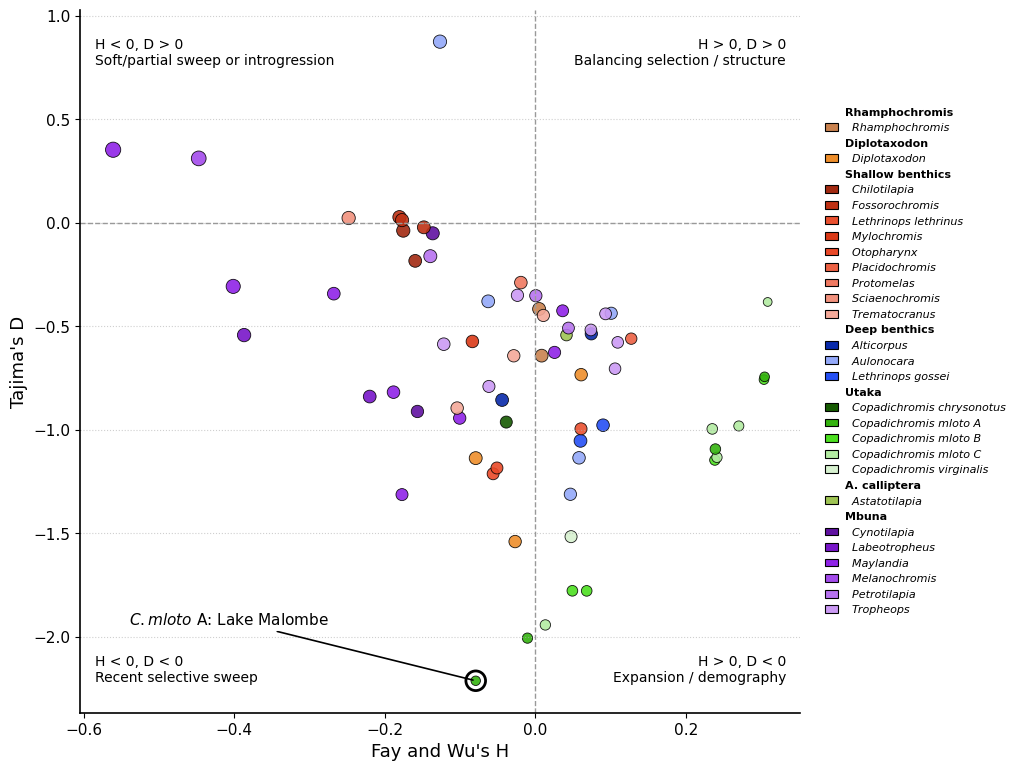

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import colorsys
from matplotlib import colors as mcolors

# --- summaries (MultiIndex columns: level0=species, level1=site) ---
mask = ~data_td_multi.columns.get_level_values("species").str.endswith('Copadichromis_mloto')
data_td_multi = data_td_multi.loc[:, mask]
mask = ~data_fwh_multi.columns.get_level_values("species").str.endswith('Copadichromis_mloto')
data_fwh_multi = data_fwh_multi.loc[:, mask]

td_mean  = data_td_multi.mean()
td_std   = data_td_multi.std()
fwh_mean = data_fwh_multi.mean()

common = td_mean.index.intersection(fwh_mean.index)
td_mean, td_std, fwh_mean = td_mean[common], td_std[common], fwh_mean[common]

mpl.rcParams.update({"axes.linewidth": 1.2, "xtick.labelsize": 11, "ytick.labelsize": 11})

species = common.get_level_values(0)
genera  = species.str.split("_").str[0]

# --- mapping and colours ---
GENUS_TO_CLADE = {
    "Rhamphochromis": "Rhamphochromis",
    "Diplotaxodon":   "Diplotaxodon",
    "Protomelas":     "Shallow benthics",
    "Placidochromis": "Shallow benthics",
    "Chilotilapia":   "Shallow benthics",
    "Sciaenochromis": "Shallow benthics",
    "Trematocranus":  "Shallow benthics",
    "Fossorochromis": "Shallow benthics",
    "Mylochromis":    "Shallow benthics",
    "Otopharynx":     "Shallow benthics",
    "Alticorpus":     "Deep benthics",
    "Aulonocara":     "Deep benthics",
    "Astatotilapia":  "A. calliptera",
    "Labeotropheus":  "Mbuna",
    "Maylandia":      "Mbuna",
    "Melanochromis":  "Mbuna",
    "Petrotilapia":   "Mbuna",
    "Tropheops":      "Mbuna",
    "Cynotilapia":    "Mbuna",
}

CLADE_BASE = {
    "Rhamphochromis":  "#865029",
    "Diplotaxodon":    "#F2AA5F",
    "Shallow benthics":"#ED6D52",
    "Deep benthics":   "#5375F6",
    "Utaka":           "#296218",
    "A. calliptera":   "#ABCC6A",
    "Mbuna":           "#9835E9",
    "Other/uncertain": "#929292",
}

clades_default = genera.map(GENUS_TO_CLADE).fillna("Other/uncertain")
df_gc = pd.DataFrame({"genus": genera, "clade": clades_default})

genus_to_color = {}
for clade_name, sub in df_gc.groupby("clade", sort=True):
    base = CLADE_BASE.get(clade_name, "#929292")
    g_list = sorted(pd.Index(sub["genus"].unique()))
    n = len(g_list)
    L_values = np.linspace(0.35, 0.78, n) if n > 1 else np.array([0.55])
    for gen, L in zip(g_list, L_values):
        genus_to_color[gen] = set_lightness(base, float(L))

SPECIES_TO_CLADE = {
    "Copadichromis_chrysonotus": "Utaka",
    "Copadichromis_mloto_A":     "Utaka",
    "Copadichromis_mloto_B":     "Utaka",
    "Copadichromis_mloto_C":     "Utaka",
    "Copadichromis_virginalis":  "Utaka",
    "Lethrinops_lethrinus":      "Shallow benthics",
    "Lethrinops_gossei":         "Deep benthics",
}

def set_hls(hex_color, L=None, S=None):
    """Keep hue; optionally set Lightness (0–1) and/or Saturation (0–1)."""
    r, g, b = mcolors.to_rgb(hex_color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    if L is not None: l = L
    if S is not None: s = S
    r2, g2, b2 = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r2, g2, b2))

def set_lightness(hex_color, L):  # backwards-compatible
    return set_hls(hex_color, L=L)

# Distinct Utaka shades (same hue; stepped L and S for real contrast)
UTAKA_SHADES = [
    set_hls(CLADE_BASE["Utaka"], L=0.18, S=0.95),  # darkest / most saturated
    set_hls(CLADE_BASE["Utaka"], L=0.38, S=0.85),
    set_hls(CLADE_BASE["Utaka"], L=0.50, S=0.75),
    set_hls(CLADE_BASE["Utaka"], L=0.78, S=0.65),
    set_hls(CLADE_BASE["Utaka"], L=0.88, S=0.55),  # lightest
]

def color_within_clade(clade, L):
    return set_lightness(CLADE_BASE.get(clade, "#929292"), L)

SPECIES_TO_COLOR = {
    # Utaka highlights (use wide-spaced shades)
    "Copadichromis_chrysonotus": UTAKA_SHADES[0],
    "Copadichromis_mloto_A":     UTAKA_SHADES[1],
    "Copadichromis_mloto_B":     UTAKA_SHADES[2],
    "Copadichromis_mloto_C":     UTAKA_SHADES[3],
    "Copadichromis_virginalis":  UTAKA_SHADES[4],

    # Lethrinops species in different clades
    "Lethrinops_lethrinus":      set_hls(CLADE_BASE["Shallow benthics"], L=0.55),
    "Lethrinops_gossei":         set_hls(CLADE_BASE["Deep benthics"],    L=0.55),
}

# Also darken the *genus* colour for Copadichromis so it stands apart from the species overrides
genus_to_color["Copadichromis"] = set_hls(CLADE_BASE["Utaka"], L=0.24, S=0.98)
base_point_colors = pd.Series(genera).map(genus_to_color)
species_s = pd.Series(np.asarray(species), index=np.arange(len(species)))
override_series = species_s.map(SPECIES_TO_COLOR)
base_point_colors.loc[override_series.notna()] = override_series.dropna()
point_colors = base_point_colors.fillna(CLADE_BASE["Other/uncertain"]).values

# --- sizes ---
std_norm = (td_std - td_std.min()) / (td_std.max() - td_std.min() + 1e-9)
sizes = 40 + 80 * std_norm

# --- plotting ---
fig, ax = plt.subplots(figsize=(10.5, 8))
ax.scatter(fwh_mean.values, td_mean.values,
           s=sizes.values, c=point_colors,
           alpha=0.9, edgecolor="black", linewidth=0.6)

ax.axvline(0, color="0.6", linestyle="--", linewidth=1)
ax.axhline(0, color="0.6", linestyle="--", linewidth=1)
ax.set_xlabel("Fay and Wu's H", fontsize=13)
ax.set_ylabel("Tajima's D", fontsize=13)
ax.yaxis.grid(True, linestyle=":", linewidth=0.8, alpha=0.6)
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

# --- annotation (manual override allowed) ---
label_key = ("Copadichromis_mloto_A", "Lake_Malombe")
ANNOTATION_LABEL = "$\it{C. mloto}$ A: Lake Malombe"

if label_key in common:
    x0, y0 = float(fwh_mean[label_key]), float(td_mean[label_key])
    ax.scatter([x0], [y0], s=200, facecolors="none",
               edgecolors="black", linewidths=2.0, zorder=4)
    ax.annotate(ANNOTATION_LABEL,
                xy=(x0, y0), xycoords="data",
                xytext=(-250, 50), textcoords="offset points",
                ha="left", va="top", fontsize=11,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", lw=0.8, alpha=0.95),
                arrowprops=dict(arrowstyle="-", lw=1.2))

# --- legend ---
CLADE_ORDER = [
    "Rhamphochromis", "Diplotaxodon",
    "Shallow benthics", "Deep benthics", "Utaka",
    "A. calliptera", "Mbuna",
]

present_highlights = {sp: col for sp, col in SPECIES_TO_COLOR.items() if (species_s == sp).any()}
spec_by_clade = {}
for sp, col in present_highlights.items():
    cl = SPECIES_TO_CLADE.get(sp, None)
    if cl: spec_by_clade.setdefault(cl, []).append(sp)

combined_handles, combined_labels = [], []
header_idx, genus_idx, species_idx = [], [], []

present_clades = [c for c in CLADE_ORDER if c in df_gc["clade"].unique() or c in spec_by_clade]

for clade_name in present_clades:
    combined_handles.append(Patch(facecolor="none", edgecolor="none"))
    combined_labels.append(clade_name)
    header_idx.append(len(combined_labels) - 1)

    # genera in this clade
    g_list = sorted(df_gc.loc[df_gc["clade"] == clade_name, "genus"].unique()) \
             if clade_name in df_gc["clade"].unique() else []

    # highlighted species in this clade
    sp_list = sorted(spec_by_clade.get(clade_name, []))

    # merge genera + species, but sort alphabetically as plain strings (after prettify)
    merged_items = []
    for gen in g_list:
        merged_items.append(("genus", gen, genus_to_color[gen]))
    for sp in sp_list:
        merged_items.append(("species", sp, SPECIES_TO_COLOR[sp]))

    merged_items = sorted(merged_items, key=lambda t: t[1].lower())

    for kind, name, col in merged_items:
        combined_handles.append(Patch(facecolor=col, edgecolor="black", linewidth=0.8))
        label_txt = f"  {name.replace('_',' ')}"
        combined_labels.append(label_txt)
        if kind == "genus":
            genus_idx.append(len(combined_labels) - 1)
        else:
            species_idx.append(len(combined_labels) - 1)

leg = ax.legend(combined_handles, combined_labels,
                fontsize=8, title_fontsize=9,
                loc="center left", bbox_to_anchor=(1.02, 0.5),
                frameon=False, ncol=1, handlelength=1.2, handletextpad=0.6)

texts = leg.get_texts()
for i in header_idx: texts[i].set_weight("bold")
for i in genus_idx:  texts[i].set_style("italic")   # italicise all genera
for i in species_idx: texts[i].set_style("italic") # italicise highlighted species too



# quadrant annotations
box = dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.9)
ax.text(0.02, 0.96, "H < 0, D > 0\nSoft/partial sweep or introgression",
        transform=ax.transAxes, ha="left", va="top", fontsize=10, bbox=box)
ax.text(0.98, 0.96, "H > 0, D > 0\nBalancing selection / structure",
        transform=ax.transAxes, ha="right", va="top", fontsize=10, bbox=box)
ax.text(0.02, 0.04, "H < 0, D < 0\nRecent selective sweep",
        transform=ax.transAxes, ha="left", va="bottom", fontsize=10, bbox=box)
ax.text(0.98, 0.04, "H > 0, D < 0\nExpansion / demography",
        transform=ax.transAxes, ha="right", va="bottom", fontsize=10, bbox=box)


plt.tight_layout()
plt.savefig(f"{ana_dir}/Output/Figures/tajimaD_fayWuH_summary_w_mbuna_3.pdf", bbox_inches="tight")
plt.savefig(f"{ana_dir}/Output/Figures/tajimaD_fayWuH_summary_w_mbuna_3.svg", bbox_inches="tight")
plt.savefig(f"{ana_dir}/Output/Figures/tajimaD_fayWuH_summary_w_mbuna_3.png", dpi=300, bbox_inches="tight")
plt.show()

## Selection scans 

 - H-out files created with snakemake: ./snakemake/hscan
 - PBS files created using FST for 3 populations in ./snakemake/fst

In [ ]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
#import colorbrewer
import yaml
from gtfparse import read_gtf
from matplotlib.backends.backend_pdf import PdfPages

import sys 
sys.path.append("/data/antwerpen/grp/asvardal/hs_tools")
from pypopgen3.modules import vcfpandas as vp

typedict = {'CHROM':'category', 'H':'float16', 'PBS_pop1':'float16', 'z_score':'float16', 'modified_z_score':'float16', 'squared_z_score':'float16'}


import subprocess

eu = os.path.expanduser
jn = os.path.join
ap = os.path.abspath

chrom_len = pd.read_csv(f'{root_dir}/reference/fAstCal1.2/GCA_900246225.3_fAstCal1.2_genomic_chromnames_mt.fa.fai',
                           sep='\t', usecols=[0,1], names=['chrom','len'], index_col=0).squeeze("columns")

chromosomes = ['chr' + str(i)for i in range(1,24) if i != 21]

In [ ]:
out_dir_hscan = '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/output/hscan'
cichlid_dir = '/scratch/antwerpen/grp/asvardal/projects/cichlid'
out_dir_fst = "/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/output/fst"


def read_pbs(fn):
    fst_df = pd.read_csv(fn,sep='\t',index_col=[0,1]).dropna().squeeze("columns")
    #fst_df.index = pd.MultiIndex.from_arrays([fst_df.index.droplevel(1),
    #                                             (fst_df.index.droplevel(0)+(fst_df['12_BIN_END']-fst_df.index.droplevel(0))/2).astype(int)])
    return fst_df

sfilter = 'pass.snps.biallelic'

dmode = 'd-1'

### Q-Q plots
comparison of Nkhudzi bay and Malombe populations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def qqplot_pop(x, y, xlabel="Sample X", ylabel="Sample Y",
               stride=2, markersize=3, alpha=0.5,
               point_color="dodgerblue", line_color="crimson",
               rasterized=False, ax=None, Text_insert=None):
    """
    Q–Q plot for same-length arrays, plotting only > 0 values.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # keep only finite pairs and both > 0
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x = np.sort(x[mask])
    y = np.sort(y[mask])

    # downsample for plotting speed (optional)
    x_plot = x[::stride]
    y_plot = y[::stride]

    # figure / axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))  # bigger, eye-catching
    else:
        fig = ax.figure

    # scatter points
    ax.plot(x_plot, y_plot, '.', markersize=markersize, alpha=alpha,
            color=point_color, markeredgecolor='none', rasterized=rasterized)

    # 45° reference line
    lo = min(x.min(), y.min())
    hi = max(x.max(), y.max())
    ax.plot([lo, hi], [lo, hi], '--', color=line_color,
            linewidth=2.0, alpha=0.9)

    # styling
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
#     ax.set_title("Q–Q plot (> 0 only)", fontsize=18, fontweight='bold', pad=15)

    ax.grid(True, linestyle=':', linewidth=1, alpha=0.7)
    ax.tick_params(labelsize=9, width=1.5, length=6, direction="out")

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    ax.set_aspect('equal', adjustable='box')
    ax.legend(fontsize=13, frameon=False, loc="upper left")
    
    box = dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.9)
    ax.text(0.02, 0.96, Text_insert,
            transform=ax.transAxes, ha="left", va="top", fontsize=16, bbox=box)
    
    fig.tight_layout()
    return fig, ax

#### Figure 2D – Q–Q H-statistic Malombe–Malawi

In [143]:
# read in h-scan results for MB and NB populations seperatly
hscan_subset_id = 'virginalis_Nkhudzi_bay_stringent_clade'

dfs = []
for chrom in chromosomes:
    fn = f"{out_dir_hscan}/H_out.{hscan_subset_id}.{sfilter}.whatshap.shapeit4.annotate.{chrom}_{dmode}.tsv"
    df = pd.read_csv(fn,sep='\t',index_col=[0])
    df['chrom'] = chrom
    dfs.append(df)

wg_hscan_NB_df = pd.concat(dfs).reset_index().set_index(['chrom', 'x'])

H_NB = wg_hscan_NB_df['H'].to_numpy()

In [ ]:
hscan_subset_id = 'virginalis_LMalombe_clade_stringent'


dfs = []
for chrom in chromosomes:
    fn = f"{out_dir_hscan}/H_out.{hscan_subset_id}.{sfilter}.whatshap.shapeit4.annotate.{chrom}_{dmode}.tsv"
    df = pd.read_csv(fn,sep='\t',index_col=[0])
    df['chrom'] = chrom
    dfs.append(df)

wg_hscan_MB_df = pd.concat(dfs).reset_index().set_index(['chrom', 'x'])

H_Malombe = wg_hscan_MB_df['H'].to_numpy()

In [146]:
## make correction for population specific H score. 

H_Malombe2 = H_Malombe - H_NB
H_NB2 = H_NB - H_Malombe

/tmp/ipykernel_2262541/1414592225.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=13, frameon=False, loc="upper left")


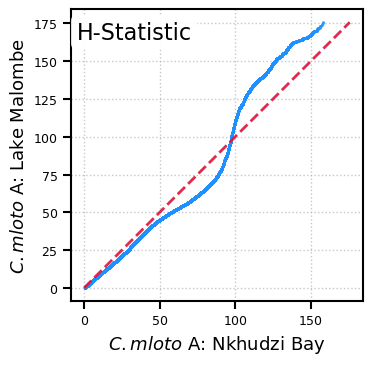

In [ ]:
# fig, ax = qqplot_pub(np.sort(H_Malombe2), np.sort(H_NB2), xlabel="Malombe", ylabel="Malawi",
#                      stride=1, markersize=1.2, alpha=0.6, rasterized=True)
fig, ax = qqplot_pop(np.sort(H_NB2),np.sort(H_Malombe2),stride=1,
                     ylabel="$\it{C. mloto}$ A: Lake Malombe", xlabel="$\it{C. mloto}$ A: Nkhudzi Bay", markersize=4, alpha=0.8,rasterized=True, Text_insert = "H-Statistic")
fig.savefig(f"{ana_dir}/Output/Figures/qq_H_statistic_malombe_malawi.pdf")  # vector with rasterized points
fig.savefig(f"{ana_dir}/Output/Figures/qq_H_statistic_malombe_malawi.svg")  # vector with rasterized points
fig.savefig(f"{ana_dir}/Output/Figures/qq_H_statistic_malombe_malawi.png", dpi=600)  # high-res PNG

## figure 2D

#### Figure 2E – Q–Q PBS Malombe–Malawi

In [ ]:
species = 'virginalis'

pbs_trio = 'Malombe--Nkhudzi-SE_arm' 

wg_pbs_MB_df = read_pbs(f"{out_dir_fst}/PBS_{species}.{pbs_trio}.{region_id}.weir.fst")
###Log corrected calculation of PBS
f = lambda x: -np.log(1-x)
wg_pbs_MB_df["PBS_log_pop1"] = 0.5 * (f(wg_pbs_MB_df["12_WEIR_AND_COCKERHAM_FST"]) + f(wg_pbs_MB_df["13_WEIR_AND_COCKERHAM_FST"]) - f(wg_pbs_MB_df["23_WEIR_AND_COCKERHAM_FST"]))

PBS_Malombe = wg_pbs_MB_df['PBS_log_pop1'].to_numpy()

# remove the -inf values
PBS_Malombe = PBS_Malombe[np.isfinite(PBS_Malombe)]

/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
species = 'virginalis'

pbs_trio = 'Nkhudzi--Malombe-SE_arm' 

wg_pbs_NB_df = read_pbs(f"{out_dir_fst}/PBS_{species}.{pbs_trio}.{region_id}.weir.fst")

###Log corrected calculation of PBS
f = lambda x: -np.log(1-x)
wg_pbs_NB_df["PBS_log_pop1"] = 0.5 * (f(wg_pbs_NB_df["12_WEIR_AND_COCKERHAM_FST"]) + f(wg_pbs_NB_df["23_WEIR_AND_COCKERHAM_FST"]) - f(wg_pbs_NB_df["13_WEIR_AND_COCKERHAM_FST"]))

PBS_NB = wg_pbs_NB_df['PBS_log_pop1'].to_numpy()

# remove the inf values
PBS_NB = PBS_NB[np.isfinite(PBS_NB)]

/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/tmp/ipykernel_2262541/1414592225.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=13, frameon=False, loc="upper left")


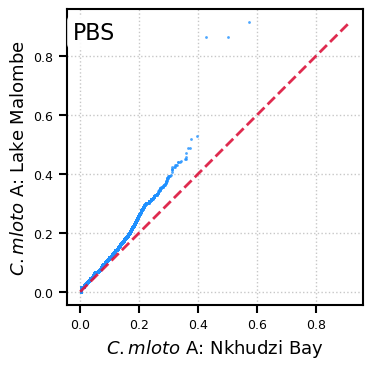

In [ ]:
fig, ax = qqplot_pop(np.sort(PBS_NB[np.isfinite(PBS_NB)]), np.sort(PBS_Malombe), stride=1,
                     ylabel="$\it{C. mloto}$ A: Lake Malombe", xlabel="$\it{C. mloto}$ A: Nkhudzi Bay", markersize=4, alpha=0.8,rasterized=True, Text_insert = "PBS")
fig.savefig(f"{ana_dir}/Output/Figures/qq_PBS_malombe_malawi.pdf")  # vector with rasterized points
fig.savefig(f"{ana_dir}/Output/Figures/qq_PBS_malombe_malawi.svg")  # vector with rasterized points
fig.savefig(f"{ana_dir}/Output/Figures/qq_PBS_malombe_malawi.png", dpi=600)  # high-res PNG

## figure 2E

## Candidate signatures across the genome

In [16]:
hscan_subset_id = 'virginalis_Malombe-Nkhudzi'
pbs_trio = 'Malombe--Nkhudzi-SE_arm'
region_id = 'wg'
species = 'virginalis'

chromosomes = ['chr' + str(i)for i in range(1,24) if i != 21]

In [ ]:
# concatanate all output files and index with chrom and position columns


dfs = []
for chrom in chromosomes:
    fn = f"{out_dir_hscan}/H_out.{hscan_subset_id}.{sfilter}.whatshap.shapeit4.annotate.{chrom}_{dmode}.tsv"
    df = pd.read_csv(fn,sep='\t',index_col=[0])
    df['chrom'] = chrom
    dfs.append(df)

wg_hscan_df = pd.concat(dfs).reset_index().set_index(['chrom', 'x'])

In [20]:
wg_pbs_df = read_pbs(f"{out_dir_fst}/PBS_{species}.{pbs_trio}.{region_id}.weir.fst")

In [ ]:
###Log corrected calculation of PBS
f = lambda x: -np.log(1-x)
wg_pbs_df["PBS_log_pop1"] = 0.5 * (f(wg_pbs_df["12_WEIR_AND_COCKERHAM_FST"]) + f(wg_pbs_df["13_WEIR_AND_COCKERHAM_FST"]) - f(wg_pbs_df["23_WEIR_AND_COCKERHAM_FST"]))


/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
wg_pbs_df.replace(-np.inf, -1, inplace=True)  # Replace -inf with NaN

### FCS calculation

as in Choin, J. https://doi.org/10.1038/s41586-021-03236-5

In [24]:
merged_H_PBS = pd.merge(wg_hscan_df.reset_index(), wg_pbs_df.reset_index(), left_index=True, right_index=True)

In [25]:
merged_H_PBS = merged_H_PBS.set_index(['chrom', 'x'])

In [26]:
merged_H_PBS

H  CHROM       POS  12_WEIR_AND_COCKERHAM_FST  \
chrom x                                                               
chr1  122       12.7260   chr1       122                   0.000000   
      149       12.7260   chr1       149                   0.000000   
      159       13.4110   chr1       159                  -0.008730   
      171       13.3740   chr1       171                   0.000000   
      186       13.3740   chr1       186                   0.000000   
...                 ...    ...       ...                        ...   
chr23 43918913  -3.1630  chr23  43918913                  -0.008730   
      43918918  -3.5758  chr23  43918918                  -0.000325   
      43919115  -2.2608  chr23  43919115                   0.004276   
      43919116  -3.1718  chr23  43919116                   0.000000   
      43919120  -3.1596  chr23  43919120                  -0.008730   

                13_WEIR_AND_COCKERHAM_FST  23_WEIR_AND_COCKERHAM_FST  \
chrom x                                                                
chr1  122                        0.041473                   0.005224   
      149                        0.000000                   0.000000   
      159                       -0.011281                   0.000000   
      171                        0.000000                   0.000000   
      186                        0.000000                   0.000000   
...                                   ...                        ...   
chr23 43918913                  -0.011281                   0.000000   
      43918918                   0.034506                  -0.009970   
      43919115                   0.017470                   0.060168   
      43919116                   0.041473                   0.005224   
      43919120                  -0.011281                   0.000000   

                PBS_pop1  PBS_log_pop1  
chrom x                                 
chr1  122       0.018124      0.018560  
      149       0.000000      0.000000  
      159      -0.010005     -0.009955  
      171       0.000000      0.000000  
      186       0.000000      0.000000  
...                  ...           ...  
chr23 43918913 -0.010005     -0.009955  
      43918918  0.022075      0.022356  
      43919115 -0.019211     -0.020072  
      43919116  0.018124      0.018560  
      43919120 -0.010005     -0.009955  

[41742485 rows x 8 columns]

In [27]:
from scipy.stats import rankdata
# Compute percentile ranks (scaled between 0 and 1)
merged_H_PBS['PBS_percentile'] = rankdata(-merged_H_PBS['PBS_log_pop1'], method='average') / len(merged_H_PBS)
merged_H_PBS['h_scores_percentile'] = rankdata(-merged_H_PBS['H'], method='average') / len(merged_H_PBS)

In [28]:
# Compute -log10 of the percentile ranks
merged_H_PBS['PBS_log_rank'] = -np.log10(merged_H_PBS['PBS_percentile'])
merged_H_PBS['h_scores_log_rank'] = -np.log10(merged_H_PBS['h_scores_percentile'])

In [29]:
# sum log rank
merged_H_PBS['FCS'] = merged_H_PBS['PBS_log_rank'] + merged_H_PBS['h_scores_log_rank']

In [30]:
print(merged_H_PBS['FCS'].max())
print(merged_H_PBS['FCS'].quantile(0.9999))

12.853766773214197
5.514167560546703


In [31]:
threshold = 5.512684762384413

See notebook simulation_output_pub.ipynb for steps to defining FCS threshold from simulations

In [32]:
ThresholdSNPs = merged_H_PBS[merged_H_PBS['FCS'] > threshold]

In [33]:
bcftools_regions_selection_snps_fn = f'{ana_dir}/Output/Genomic_features/candidate_regions_chr-pos_4185.txt'

with open(bcftools_regions_selection_snps_fn, "w") as fh:
    for chrom,pos in ThresholdSNPs.index:
        string = str(chrom)+"\t"+str(pos)
#         print(string)
        fh.write(string + "\n")

### Candidate regions

In [97]:
def compute_min_covering_windows(
    merged_H_PBS,
    chromosomes,
    threshold,
    flank_bp=25_000,
    verbose=True,
    clip_start_at_1=True,
):
    """
    For each chromosome in `chromosomes`, find SNPs with FCS > threshold,
    create ±flank_bp windows around each outlier, merge overlapping/touching
    windows, and return totals + per-chromosome results.

    Parameters
    ----------
    merged_H_PBS : pandas.DataFrame or pandas.core.indexing._LocIndexer
        Indexed so that `merged_H_PBS.loc[chrom]` yields a DataFrame with at
        least columns: 'POS' (int, bp) and 'FCS' (float).
    chromosomes : list[str]
        Chromosome names to process (e.g., ["1", "2", ..., "22"] or ["chr1",...]).
    threshold : float
        Outlier cutoff applied as FCS > threshold.
    flank_bp : int, default 25_000
        Half-window size on each side (final window width = 2 * flank_bp).
    verbose : bool, default True
        If True, prints a summary per chromosome and overall totals.
    clip_start_at_1 : bool, default True
        If True, negative window starts are clipped to 1.

    Returns
    -------
    results : dict
        {
          'total_outlier_snps': int,
          'total_windows': int,
          'per_chrom': {
             chrom: {
               'outlier_snps': int,
               'windows': list[tuple[int, int]]  # merged, non-overlapping
             }, ...
          }
        }
    """
    def merge_intervals(intervals):
        """
        Merge overlapping or touching intervals.
        Intervals are (start, end). Assumes start/end are ints.
        Touching means next.start <= curr_end (inclusive merge).
        """
        if not intervals:
            return []
        intervals = sorted(intervals, key=lambda x: (x[0], x[1]))
        merged = [list(intervals[0])]
        for s, e in intervals[1:]:
            last_s, last_e = merged[-1]
            if s <= last_e:  # overlap or touch -> merge
                merged[-1][1] = max(last_e, e)
            else:
                merged.append([s, e])
        return [tuple(x) for x in merged]

    per_chrom_results = {}
    total_outliers = 0
    total_windows = 0

    for chrom in chromosomes:
        try:
            df_chrom = merged_H_PBS.loc[chrom]
        except KeyError:
            # No data for this chromosome
            per_chrom_results[chrom] = {'outlier_snps': 0, 'windows': []}
            if verbose:
                print("------------------------------------------------------------")
                print(f"Chromosome: {chrom}")
                print("Number of merged windows                          : 0")
                print("Total FCS outlier SNPs in chromosome              : 0")
            continue

        # Ensure required columns exist
        if not {'POS', 'FCS'}.issubset(df_chrom.columns):
            raise ValueError(f"Chromosome {chrom} missing POS/FCS columns.")

        # Get outliers
        outliers = df_chrom[df_chrom['FCS'] > threshold].copy()
        outlier_count = int(outliers.shape[0])
        total_outliers += outlier_count

        # Build raw windows around each outlier position
        raw_windows = []
        if outlier_count > 0:
            for pos in outliers['POS'].sort_values().astype(int):
                start = pos - flank_bp
                end = pos + flank_bp
                if clip_start_at_1:
                    start = max(1, start)
                raw_windows.append((start, end))

        # Merge to obtain minimum set covering all outliers
        merged_windows = merge_intervals(raw_windows)
        per_chrom_results[chrom] = {
            'outlier_snps': outlier_count,
            'windows': merged_windows,
        }

        total_windows += len(merged_windows)

        if verbose:
            print("------------------------------------------------------------")
            print(f"Chromosome: {chrom}")
            print("Number of merged windows                          :", len(merged_windows))
            print("Total FCS outlier SNPs in chromosome              :", outlier_count)

    if verbose:
        print("------------------------------------------------------------")
        print("Total number of merged windows across genome      :", total_windows)
        print("Total number of FCS outlier SNPs across genome    :", total_outliers)

    return {
        'total_outlier_snps': total_outliers,
        'total_windows': total_windows,
        'per_chrom': per_chrom_results,
    }

In [98]:
window_size = 25000
threshold = 5.512684762384413

results = compute_min_covering_windows(
    merged_H_PBS,
    chromosomes,
    threshold=threshold,
    flank_bp=window_size,
    verbose=True,
)

# Access outputs:
total_windows = results['total_windows']
total_outliers = results['total_outlier_snps']
merged_window_limits = {chrom: v['windows'] for chrom, v in results['per_chrom'].items()}

------------------------------------------------------------
Chromosome: chr1
Number of merged windows                          : 39
Total FCS outlier SNPs in chromosome              : 1203
------------------------------------------------------------
Chromosome: chr2
Number of merged windows                          : 27
Total FCS outlier SNPs in chromosome              : 191
------------------------------------------------------------
Chromosome: chr3
Number of merged windows                          : 26
Total FCS outlier SNPs in chromosome              : 362
------------------------------------------------------------
Chromosome: chr4
Number of merged windows                          : 11
Total FCS outlier SNPs in chromosome              : 14
------------------------------------------------------------
Chromosome: chr5
Number of merged windows                          : 14
Total FCS outlier SNPs in chromosome              : 21
--------------------------------------------------------

In [99]:
def dict_of_dict_to_list(dictionary):
    result = []
    for outer_key, inner_dict in dictionary.items():
        for inner_key, inner_value in inner_dict.items():
            temp = f"{outer_key}:{inner_key}-{inner_value}"
            result.append(temp)
    return result

merged_window_limits_dict = {
    chrom: {s: e for (s, e) in wins}
    for chrom, wins in merged_window_limits.items()
}

chrpos_list = dict_of_dict_to_list(merged_window_limits_dict)


In [100]:
print(len(chrpos_list))

473


In [101]:
bcftools_regions_fn = f"{ana_dir}/Output/Genomic_features/candidate_regions473_chr:start-end.txt"

with open(bcftools_regions_fn, "w") as fh:
    for i in chrpos_list:
        string = "\t".join(i.split(':'))
        string = "\t".join(string.split('-'))
        fh.write(string + "\n")

#### top 10 regions

In [171]:
flank_size = 25000
threshold = 8.25 # threshold arbitrary

results = compute_min_covering_windows(
    merged_H_PBS,
    chromosomes,
    threshold=threshold,
    flank_bp=flank_size,
    verbose=True,
)

# Access outputs:
total_windows = results['total_windows']
total_outliers = results['total_outlier_snps']
merged_window_limits = {chrom: v['windows'] for chrom, v in results['per_chrom'].items()}

------------------------------------------------------------
Chromosome: chr1
Number of merged windows                          : 1
Total FCS outlier SNPs in chromosome              : 144
------------------------------------------------------------
Chromosome: chr2
Number of merged windows                          : 1
Total FCS outlier SNPs in chromosome              : 1
------------------------------------------------------------
Chromosome: chr3
Number of merged windows                          : 1
Total FCS outlier SNPs in chromosome              : 1
------------------------------------------------------------
Chromosome: chr4
Number of merged windows                          : 0
Total FCS outlier SNPs in chromosome              : 0
------------------------------------------------------------
Chromosome: chr5
Number of merged windows                          : 0
Total FCS outlier SNPs in chromosome              : 0
------------------------------------------------------------
Chromos

In [172]:
merged_window_limits_dict = {
    chrom: {s: e for (s, e) in wins}
    for chrom, wins in merged_window_limits.items()
}

chrpos_list = dict_of_dict_to_list(merged_window_limits_dict)


In [173]:
chrpos_list

['chr1:39406357-39772713',
 'chr2:11606365-11656365',
 'chr3:3326518-3376518',
 'chr6:6472995-6582963',
 'chr7:10285777-10338291',
 'chr7:44175985-44244688',
 'chr12:5505879-5557210',
 'chr12:6036511-6086511',
 'chr20:8335345-8385356',
 'chr23:20791821-20843857']

In [174]:
bcftools_regions_fn_ultra = f"{ana_dir}/Output/Genomic_features/candidate_regions10_chr:start-end.txt"

with open(bcftools_regions_fn_ultra, "w") as fh:
    for i in chrpos_list:
        string = "\t".join(i.split(':'))
        string = "\t".join(string.split('-'))
        fh.write(string + "\n")

### Explore SNP effects of different SNP subsets

In [105]:
def run_command(command):
    """
    Runs a command in the shell and captures the output as a string.
    """
    p = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output_bytes, error_bytes = p.communicate()
    exit_code = p.returncode
    if exit_code != 0:
        print(f"Error running command: {command}")
        print(f"Error message: {error_bytes.decode('utf-8')}")
        return None
    return output_bytes.decode('utf-8')

In [106]:
snpeff_path = "/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/share/snpeff-5.2-1"
snpsift_path = "/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/share/snpsift-5.2-0"

anno_vcf_fn_gz = f"{ana_dir}/_data/VariantCalling/fAstCal1.2/15april/all_sites.tif1.sft1.pass.snps.biallelic.whatshap.shapeit4.annotate.anc_samp.snpEff_anno_fAstcal1.2.105.wg.vcf.gz"

samples_Malombe2017 = "cichlid6779945,cichlid7050677,cichlid6779958,cichlid6779935,cichlid6779959,cichlid6779919,cichlid7020331,cichlid6779934,cichlid6779926,cichlid7020326,cichlid6779961,cichlid7020329,cichlid6779957,cichlid7020325,cichlid6779944,cichlid6779933,cichlid7020327,cichlid6779920,cichlid6779943,cichlid6779932,cichlid6779927,cichlid6779922,cichlid6779930,cichlid7020330,cichlid6779925,cichlid6779924,cichlid6779921,cichlid6779923,cichlid6779931,cichlid6779928,cichlid6779929,cichlid7020328,ILBCDS5879587,ILBCDS5879585"
samples_Malombe2002 = "CopAnsF17350461,CopAnsF17350467,CopAnsF17350462,CopAnsF17350464,CopAnsF17350459,CopAnsF17350465,CopAnsF17350463,CopAnsF17350458,CopAnsF17350456,CopAnsF18116180,CopAnsF18116173,CopAnsF18116262,CopAnsF18116188,CopAnsF18116189,CopAnsF18116222,CopAnsF18116182,CopAnsF18116221,CopAnsF18116198,CopAnsF18116245,CopAnsF18116213,CopAnsF18116296,CopAnsF18116256,CopAnsF18116220,CopAnsF18116260,CopAnsF18116254,CopAnsF18116252,CopAnsF18116174,CopAnsF18116280,CopAnsF18116236,CopAnsF18116206,CopAnsF18116304,CopAnsF18116246,CopAnsF18116261,CopAnsF18116229,CopAnsF18116237,CopAnsF18116204,CopAnsF18116288,CopAnsF18116228,CopAnsF18116197,CopAnsF18116212,CopAnsF18116196,CopAnsF18116190,CopAnsF18116244,CopAnsF18116238,CopAnsF18116181,CopAnsF18116214"
samples_NB = "CopAnsF18116332,CopAnsF18116354,CopAnsF18116324,CopAnsF18116348,CopAnsF18116278,CopAnsF18116362,CopAnsF18116325,CopAnsF18116286,CopAnsF18116285,CopAnsF18116341,CopAnsF18116294,CopAnsF18116293,CopAnsF18116349,CopAnsF18116301,CopAnsF18116309,CopAnsF18116277,CopAnsF18116330,CopAnsF18116318,CopAnsF18116302,CopAnsF18116317,CopAnsF18116270,CopAnsF18116357,CopAnsF18116356,CopAnsF18116310,CopAnsF18116322,CopAnsF18116333"
samp_Malombe_NB = samples_NB+","+samples_Malombe2002+","+samples_Malombe2017+",ancestral"

sample_string = samp_Malombe_NB

In [107]:
# check
search_command = f"java -Xmx4g -jar {snpeff_path}/snpEff.jar databases | grep -i fAstCal"
run_command(search_command)

'fAstCal1.2.105                                              \tAstatotilapia_calliptera                                    \tOK        \t                              \t[https://snpeff.blob.core.windows.net/databases/v5_2/snpEff_v5_2_fAstCal1.2.105.zip, https://snpeff.blob.core.windows.net/databases/v5_0/snpEff_v5_0_fAstCal1.2.105.zip, https://snpeff.blob.core.windows.net/databases/v5_1/snpEff_v5_1_fAstCal1.2.105.zip]\nfAstCal1.2.99                                               \tAstatotilapia_calliptera                                    \tOK        \t                              \t[https://snpeff.blob.core.windows.net/databases/v5_2/snpEff_v5_2_fAstCal1.2.99.zip, https://snpeff.blob.core.windows.net/databases/v5_0/snpEff_v5_0_fAstCal1.2.99.zip, https://snpeff.blob.core.windows.net/databases/v5_1/snpEff_v5_1_fAstCal1.2.99.zip]\n'

- 2025-08-10: fAstCal1.2.105 available

In [108]:
command_anno_file = f"java -Xmx4g -jar {snpeff_path}/snpEff.jar -c {snpeff_path}/snpEff.config -v fAstCal1.2.105 /scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/_data/VariantCalling/fAstCal1.2/15april/all_sites.tif1.sft1.pass.snps.biallelic.whatshap.shapeit4.annotate.anc_samp.wg.vcf.gz > {anno_vcf_fn_gz}"

In [109]:
print(command_anno_file)

java -Xmx4g -jar /data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/share/snpeff-5.2-1/snpEff.jar -c /data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/share/snpeff-5.2-1/snpEff.config -v fAstCal1.2.105 /scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/_data/VariantCalling/fAstCal1.2/15april/all_sites.tif1.sft1.pass.snps.biallelic.whatshap.shapeit4.annotate.anc_samp.wg.vcf.gz > /scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/_data/VariantCalling/fAstCal1.2/15april/all_sites.tif1.sft1.pass.snps.biallelic.whatshap.shapeit4.annotate.anc_samp.snpEff_anno_fAstcal1.2.105.wg.vcf.gz


- created large SNPEFF annotated vcf with command_anno_file above ^ !long runtime in notebook.

- gz compress anno_vcf, and create index

#### SNPeff for all snps in candidate regions, in ultra high regions (top 10 peaks) and for the SNPs surpassing threshold. 

In [110]:
bcftools_regions_candidate_regions_fn = f'{ana_dir}/Output/Genomic_features/candidate_regions473_chr:start-end.txt'
tsv_snpeff_candidate_regions = f'{ana_dir}/Output/Genomic_features/anno_effect_per_snp_473candidate_regions.txt'

command1 = f"bcftools view -R {bcftools_regions_candidate_regions_fn} --samples {sample_string} {anno_vcf_fn_gz} -o temp.vcf"
command2 = f'{snpsift_path}/SnpSift extractFields -s ‘,’ temp.vcf "CHROM" "POS" "REF" "ALT" "ANN[*].GENE" "ANN[*].EFFECT" > {tsv_snpeff_candidate_regions}'
command3 = "rm temp.vcf"

run_command(command1)
run_command(command2)
run_command(command3)

''

In [111]:
bcftools_regions_selection_snps_fn = f'{ana_dir}/Output/Genomic_features/candidate_regions_chr-pos_4185.txt'
tsv_snpeff_selction_snps = f'{ana_dir}/Output/Genomic_features/anno_effect_per_snp_4185.txt'

command1 = f"bcftools view -R {bcftools_regions_selection_snps_fn} --samples {sample_string} {anno_vcf_fn_gz} -o temp.vcf"
command2 = f'{snpsift_path}/SnpSift extractFields -s ‘,’ temp.vcf "CHROM" "POS" "REF" "ALT" "ANN[*].GENE" "ANN[*].EFFECT" > {tsv_snpeff_selction_snps}'
command3 = "rm temp.vcf"

run_command(command1)
run_command(command2)
run_command(command3)

''

In [112]:
bcftools_regions_fn_ultra = f"{ana_dir}/Output/Genomic_features/candidate_regions10_chr:start-end.txt"
tsv_snpeff_ultra = f"{ana_dir}/Output/Genomic_features/anno_effect_per_snp_10candidate_regions.txt"

command1 = f"bcftools view -R {bcftools_regions_fn_ultra} --samples {sample_string} {anno_vcf_fn_gz} -o temp.vcf"
command2 = f'{snpsift_path}/SnpSift extractFields -s ‘,’ temp.vcf "CHROM" "POS" "REF" "ALT" "ANN[*].GENE" "ANN[*].EFFECT" > {tsv_snpeff_ultra}'
command3 = "rm temp.vcf"

run_command(command1)
run_command(command2)
run_command(command3)

''

#### Call candidate genes

In [28]:
import gtfparse
from gtfparse import read_gtf

gtf_ensembl = read_gtf(f'{ana_dir}/_data/Genomic_features/Astatotilapia_calliptera.fAstCal1.2.110_chrnames.gtf')

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_source', 'transcript_biotype', 'tag', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'gene_name', 'transcript_name', 'projection_parent_gene', 'projection_parent_transcript']


##### Selection SNPS

In [407]:
#TSV from previous step
tsv_snpeff_selction_snps = f'{ana_dir}/Output/Genomic_features/anno_effect_per_snp_4185.txt'
ann_candidate_regions = pd.read_csv(tsv_snpeff_selction_snps, sep = '\t')

In [409]:
##because"intergenic regions are literally regions inbetween genes"
ann_candidate_regions_wo_intergeneic = ann_candidate_regions[ann_candidate_regions['ANN[*].EFFECT'] != 'intergenic_region']
print(len(ann_candidate_regions_wo_intergeneic))

# Some variants have more than one annotated effect. Rearrange to have one effect per row and remove duplicate rows.
ann_candidate_regions_wo_intergeneic = ann_candidate_regions_wo_intergeneic.set_index(['CHROM', 'POS','REF','ALT']).apply(lambda x: x.str.split(',').explode()).reset_index().drop_duplicates(subset=None, keep='first', inplace=False)

ann_candidate_regions_wo_intergeneic['chr:pos'] = [f'{c}:{p}' for c, p in list(zip(ann_candidate_regions_wo_intergeneic['CHROM'],ann_candidate_regions_wo_intergeneic['POS']))]
ann_candidate_regions_wo_intergeneic = ann_candidate_regions_wo_intergeneic.replace(r"’", r'', regex=True)
ann_candidate_regions_wo_intergeneic = ann_candidate_regions_wo_intergeneic.replace(r"‘", r'', regex=True)

# List of all genes which are contained within outlier windows
list_genes=[]
for g in [str(i).split('-') for i in ann_candidate_regions_wo_intergeneic['ANN[*].GENE'].unique()]:
    for element in g:
        if element not in list_genes:
            list_genes.append(element)
print(len(list_genes))

2081
583


In [410]:
print(len(ann_candidate_regions))
# Some variants have more than one annotated effect. Rearrange to have one effect per row and remove duplicate rows.
ann_candidate_regions = ann_candidate_regions.set_index(['CHROM', 'POS','REF','ALT']).apply(lambda x: x.str.split(',').explode()).reset_index().drop_duplicates(subset=None, keep='first', inplace=False)

ann_candidate_regions['chr:pos'] = [f'{c}:{p}' for c, p in list(zip(ann_candidate_regions['CHROM'],ann_candidate_regions['POS']))]
ann_candidate_regions = ann_candidate_regions.replace(r"’", r'', regex=True)
ann_candidate_regions = ann_candidate_regions.replace(r"‘", r'', regex=True)

##because"intergenic regions are literally regions inbetween genes"
ann_candidate_regions_wo_intergeneic = ann_candidate_regions[ann_candidate_regions['ANN[*].EFFECT'] != 'intergenic_region']
print(len(ann_candidate_regions_wo_intergeneic))


# List of all genes which are contained within outlier windows
list_genes=[]
for g in [str(i).split('-') for i in ann_candidate_regions_wo_intergeneic['ANN[*].GENE'].unique()]:
    for element in g:
        if element not in list_genes:
            list_genes.append(element)
print(len(list_genes))

4185
4140
514


In [411]:
import pandas as pd

# Build mapping from gene_id -> gene_name
gene_name_dict = dict(zip(gtf_ensembl['gene_id'], gtf_ensembl['gene_name']))

symbol_list_genes = []
for g in list_genes:
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

print(f"Original count: {len(symbol_list_genes)}")
print(f"After cleaning: {len(unique_symbols)}")
print(f"Removed {len(symbol_list_genes) - len(unique_symbols)} duplicates/artifacts")

# Save clean file
out_path = f"{ana_dir}/Output/Genomic_features/gene_list_candidate_SNPs_4185_clean.txt"
with open(out_path, "w") as fh:
    for s in unique_symbols:
        fh.write(s + "\n")

Original count: 514
After cleaning: 509
Removed 5 duplicates/artifacts


##### All SNPS in candidate regions

In [412]:
tsv_snpeff_candidate_regions = f'{ana_dir}/Output/Genomic_features/anno_effect_per_snp_473candidate_regions.txt'

ann_candidate_regions = pd.read_csv(tsv_snpeff_candidate_regions, sep = '\t')

In [413]:
print(len(ann_candidate_regions))
# Some variants have more than one annotated effect. Rearrange to have one effect per row and remove duplicate rows.
ann_candidate_regions = ann_candidate_regions.set_index(['CHROM', 'POS','REF','ALT']).apply(lambda x: x.str.split(',').explode()).reset_index().drop_duplicates(subset=None, keep='first', inplace=False)

ann_candidate_regions['chr:pos'] = [f'{c}:{p}' for c, p in list(zip(ann_candidate_regions['CHROM'],ann_candidate_regions['POS']))]
ann_candidate_regions = ann_candidate_regions.replace(r"’", r'', regex=True)
ann_candidate_regions = ann_candidate_regions.replace(r"‘", r'', regex=True)

##because"intergenic regions are literally regions inbetween genes"
ann_candidate_regions_wo_intergeneic = ann_candidate_regions[ann_candidate_regions['ANN[*].EFFECT'] != 'intergenic_region']
print(len(ann_candidate_regions_wo_intergeneic))


# List of all genes which are contained within outlier windows
list_genes=[]
for g in [str(i).split('-') for i in ann_candidate_regions_wo_intergeneic['ANN[*].GENE'].unique()]:
    for element in g:
        if element not in list_genes:
            list_genes.append(element)
print(len(list_genes))

1287275
1665155
1168


In [414]:
import pandas as pd

# Build mapping from gene_id -> gene_name
gene_name_dict = dict(zip(gtf_ensembl['gene_id'], gtf_ensembl['gene_name']))

symbol_list_genes = []
for g in list_genes:
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

print(f"Original count: {len(symbol_list_genes)}")
print(f"After cleaning: {len(unique_symbols)}")
print(f"Removed {len(symbol_list_genes) - len(unique_symbols)} duplicates/artifacts")

# Save clean file
out_path = f"{ana_dir}/Output/Genomic_features/gene_list_candidate_473_clean.txt"
with open(out_path, "w") as fh:
    for s in unique_symbols:
        fh.write(s + "\n")

Original count: 1168
After cleaning: 1155
Removed 13 duplicates/artifacts


##### top 10 FCS peaks regions

In [415]:
#TSV from previous step
tsv_snpeff_ultra = f"{ana_dir}/Output/Genomic_features/anno_effect_per_snp_10candidate_regions.txt"

ann_candidate_regions = pd.read_csv(tsv_snpeff_ultra, sep = '\t')

In [416]:
print(len(ann_candidate_regions))
# Some variants have more than one annotated effect. Rearrange to have one effect per row and remove duplicate rows.
ann_candidate_regions = ann_candidate_regions.set_index(['CHROM', 'POS','REF','ALT']).apply(lambda x: x.str.split(',').explode()).reset_index().drop_duplicates(subset=None, keep='first', inplace=False)

ann_candidate_regions['chr:pos'] = [f'{c}:{p}' for c, p in list(zip(ann_candidate_regions['CHROM'],ann_candidate_regions['POS']))]
ann_candidate_regions = ann_candidate_regions.replace(r"’", r'', regex=True)
ann_candidate_regions = ann_candidate_regions.replace(r"‘", r'', regex=True)

##because "intergenic regions are literally regions inbetween genes"
ann_candidate_regions_wo_intergeneic = ann_candidate_regions[ann_candidate_regions['ANN[*].EFFECT'] != 'intergenic_region']
print(len(ann_candidate_regions_wo_intergeneic))

# List of all genes which are contained within outlier windows
list_genes=[]
for g in [str(i).split('-') for i in ann_candidate_regions_wo_intergeneic['ANN[*].GENE'].unique()]:
    for element in g:
        if element not in list_genes:
            list_genes.append(element)
print(len(list_genes))

24896
21864
24


In [417]:
import pandas as pd

# Build mapping from gene_id -> gene_name
gene_name_dict = dict(zip(gtf_ensembl['gene_id'], gtf_ensembl['gene_name']))

symbol_list_genes = []
for g in list_genes:
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

print(f"Original count: {len(symbol_list_genes)}")
print(f"After cleaning: {len(unique_symbols)}")
print(f"Removed {len(symbol_list_genes) - len(unique_symbols)} duplicates/artifacts")

# Save clean file
out_path = f"{ana_dir}/Output/Genomic_features/gene_list_candidate_10_clean.txt"
with open(out_path, "w") as fh:
    for s in unique_symbols:
        fh.write(s + "\n")


Original count: 24
After cleaning: 24
Removed 0 duplicates/artifacts


### SNP effects under selection

In [419]:
# tsv_snpeff_candidate_regions = f'{ana_dir}/Output/Genomic_features/anno_effect_per_snp_473candidate_regions.txt'
tsv_snpeff_selction_snps = f'{ana_dir}/Output/Genomic_features/anno_effect_per_snp_4185.txt'
# tsv_snpeff_ultra = f"{ana_dir}/Output/Genomic_features/anno_effect_per_snp_10candidate_regions.txt"


In [420]:
tsv_snpeff_selction_snps = f'{ana_dir}/Output/Genomic_features/anno_effect_per_snp_4185.txt'
ann_candidate_regions = pd.read_csv(tsv_snpeff_selction_snps, sep = '\t')

In [421]:
# Some variants have more than one annotated effect. Rearrange to have one effect per row and remove duplicate rows.
ann_candidate_regions = ann_candidate_regions.set_index(['CHROM', 'POS','REF','ALT']).apply(lambda x: x.str.split(',').explode()).reset_index().drop_duplicates(subset=None, keep='first', inplace=False)

ann_candidate_regions['chr:pos'] = [f'{c}:{p}' for c, p in list(zip(ann_candidate_regions['CHROM'],ann_candidate_regions['POS']))]
ann_candidate_regions = ann_candidate_regions.replace(r"’", r'', regex=True)
ann_candidate_regions = ann_candidate_regions.replace(r"‘", r'', regex=True)


In [422]:
ann_candidate_regions

CHROM       POS REF ALT                            ANN[*].GENE  \
0      chr1   3607696   G   A  ENSACLG00000003943-ENSACLG00000004186   
1      chr1   3721004   G   A  ENSACLG00000004186-ENSACLG00000004213   
2      chr1   3811953   G   A  ENSACLG00000004186-ENSACLG00000004213   
3      chr1   3812414   C   A  ENSACLG00000004186-ENSACLG00000004213   
4      chr1   3815582   G   T  ENSACLG00000004186-ENSACLG00000004213   
...     ...       ...  ..  ..                                    ...   
7281  chr23  36069746   G   A  ENSACLG00000027597-ENSACLG00000027626   
7282  chr23  36625343   G   C                     ENSACLG00000027654   
7283  chr23  36625343   G   C                     ENSACLG00000027654   
7284  chr23  42828850   G   C  ENSACLG00000008798-ENSACLG00000009077   
7285  chr23  43384796   G   A  ENSACLG00000010036-ENSACLG00000010041   

              ANN[*].EFFECT         chr:pos  
0         intergenic_region    chr1:3607696  
1         intergenic_region    chr1:3721004  
2         intergenic_region    chr1:3811953  
3         intergenic_region    chr1:3812414  
4         intergenic_region    chr1:3815582  
...                     ...             ...  
7281      intergenic_region  chr23:36069746  
7282  upstream_gene_variant  chr23:36625343  
7283         intron_variant  chr23:36625343  
7284      intergenic_region  chr23:42828850  
7285      intergenic_region  chr23:43384796  

[6711 rows x 7 columns]

In [423]:
list_effects = list(ann_candidate_regions.groupby('ANN[*].EFFECT').apply(len).index)
list_effects = list(map(lambda list_effects: list_effects.replace('&', ' & '), list_effects))
list_effects = list(map(lambda list_effects: list_effects.replace('_', ' '), list_effects))

/tmp/ipykernel_3209094/787532393.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  list_effects = list(ann_candidate_regions.groupby('ANN[*].EFFECT').apply(len).index)


In [424]:
observed = {
    'EFFECT': list_effects,
    'Count': list(ann_candidate_regions.groupby('ANN[*].EFFECT').apply(len).astype('int'))
}       

/tmp/ipykernel_3209094/3203160801.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Count': list(ann_candidate_regions.groupby('ANN[*].EFFECT').apply(len).astype('int'))


In [425]:
observed

{'EFFECT': ['3 prime UTR variant',
  '5 prime UTR variant',
  'downstream gene variant',
  'intergenic region',
  'intron variant',
  'missense variant',
  'missense variant & splice region variant',
  'splice acceptor variant & intron variant',
  'splice region variant & intron variant',
  'splice region variant & synonymous variant',
  'stop gained',
  'synonymous variant',
  'upstream gene variant'],
 'Count': [155, 20, 596, 2571, 2596, 116, 3, 1, 5, 6, 1, 98, 543]}

#### Call genes protein coding SNPS

In [426]:
tsv_snpeff_selction_snps = f'{ana_dir}/Output/Genomic_features/anno_effect_per_snp_4185.txt'
ann_candidate_regions = pd.read_csv(tsv_snpeff_selction_snps, sep = '\t')


# Some variants have more than one annotated effect. Rearrange to have one effect per row and remove duplicate rows.
ann_candidate_regions = ann_candidate_regions.set_index(['CHROM', 'POS','REF','ALT']).apply(lambda x: x.str.split(',').explode()).reset_index().drop_duplicates(subset=None, keep='first', inplace=False)

ann_candidate_regions['chr:pos'] = [f'{c}:{p}' for c, p in list(zip(ann_candidate_regions['CHROM'],ann_candidate_regions['POS']))]
ann_candidate_regions = ann_candidate_regions.replace(r"’", r'', regex=True)
ann_candidate_regions = ann_candidate_regions.replace(r"‘", r'', regex=True)


# definitely non-synonymous
effects_definite = [
    'missense_variant',
    'missense_variant&splice_region_variant',
    'initiator_codon_variant',
    'start_lost',
    'start_lost&splice_region_variant',
    'stop_gained',
    'stop_gained&splice_region_variant',
    'stop_lost',
    'stop_lost&splice_region_variant'
]

# potentially non-synonymous (splice-related)
effects_potential = [
    'splice_acceptor_variant&intron_variant',
    'splice_donor_variant&intron_variant',
    'splice_region_variant',
    'splice_region_variant&intron_variant',
    'splice_region_variant&non_coding_transcript_exon_variant',
    'splice_region_variant&stop_retained_variant',
    'splice_region_variant&synonymous_variant'
]

# combine lists if you want both categories
effects_all = effects_definite #+ effects_potential

# filter and get unique gene names
genes_non_syn = (
    ann_candidate_regions[
        ann_candidate_regions['ANN[*].EFFECT'].isin(effects_all)
    ]
    .drop_duplicates('ANN[*].GENE')['ANN[*].GENE']
)

In [427]:
ann_candidate_regions

CHROM       POS REF ALT                            ANN[*].GENE  \
0      chr1   3607696   G   A  ENSACLG00000003943-ENSACLG00000004186   
1      chr1   3721004   G   A  ENSACLG00000004186-ENSACLG00000004213   
2      chr1   3811953   G   A  ENSACLG00000004186-ENSACLG00000004213   
3      chr1   3812414   C   A  ENSACLG00000004186-ENSACLG00000004213   
4      chr1   3815582   G   T  ENSACLG00000004186-ENSACLG00000004213   
...     ...       ...  ..  ..                                    ...   
7281  chr23  36069746   G   A  ENSACLG00000027597-ENSACLG00000027626   
7282  chr23  36625343   G   C                     ENSACLG00000027654   
7283  chr23  36625343   G   C                     ENSACLG00000027654   
7284  chr23  42828850   G   C  ENSACLG00000008798-ENSACLG00000009077   
7285  chr23  43384796   G   A  ENSACLG00000010036-ENSACLG00000010041   

              ANN[*].EFFECT         chr:pos  
0         intergenic_region    chr1:3607696  
1         intergenic_region    chr1:3721004  
2         intergenic_region    chr1:3811953  
3         intergenic_region    chr1:3812414  
4         intergenic_region    chr1:3815582  
...                     ...             ...  
7281      intergenic_region  chr23:36069746  
7282  upstream_gene_variant  chr23:36625343  
7283         intron_variant  chr23:36625343  
7284      intergenic_region  chr23:42828850  
7285      intergenic_region  chr23:43384796  

[6711 rows x 7 columns]

In [ ]:
import pandas as pd

# Build mapping from gene_id -> gene_name
gene_name_dict = dict(zip(gtf_ensembl['gene_id'], gtf_ensembl['gene_name']))

symbol_list_genes = []
for g in list(genes_non_syn):
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

print(f"Original count: {len(symbol_list_genes)}")
print(f"After cleaning: {len(unique_symbols)}")
print(f"Removed {len(symbol_list_genes) - len(unique_symbols)} duplicates/artifacts")

# Save clean file
out_path = f"{ana_dir}/Output/Genomic_features/gene_list_protein_changes_candidate_SNPs_clean.txt"
with open(out_path, "w") as fh:
    for s in unique_symbols:
        fh.write(s + "\n")

Original count: 37
After cleaning: 37
Removed 0 duplicates/artifacts


In [127]:
unique_symbols

['ENSACLG00000009574',
 'slc22a18',
 'ENSACLG00000001162',
 'ENSACLG00000001233',
 'csrp3',
 'e2f8',
 'prmt3',
 'ENSACLG00000003648',
 'ANK2',
 'stab1',
 'mtmr7b',
 'ENSACLG00000005070',
 'ENSACLG00000005108',
 'ENSACLG00000013470',
 'ENSACLG00000021917',
 'ENSACLG00000026939',
 'ENSACLG00000015257',
 'ENSACLG00000026972',
 'hbae5',
 'tob1b',
 'ENSACLG00000022163',
 'ENSACLG00000010509',
 'GCN1',
 'upb1',
 'ENSACLG00000002164',
 'znf703',
 'NPFFR1',
 'tet3',
 'ENSACLG00000003998',
 'ENSACLG00000019915',
 'hadhb',
 'ABHD8',
 'ENSACLG00000012795',
 'ENSACLG00000011818',
 'ENSACLG00000006726',
 'ENSACLG00000008501',
 'ENSACLG00000008715']

#### random resampling of SNP effects

run snakemake "Iterate_SNPEFF" to create f"{ana_dir}/Output/SNPEFF_resampling/eff-per-pos_AF-matched_SNPs_10_iterations_{iteration}.txt"

In [128]:
n_iterations = 100 
annotations = list(ann_candidate_regions.groupby('ANN[*].EFFECT').apply(len).index)

/tmp/ipykernel_3209094/867033329.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annotations = list(ann_candidate_regions.groupby('ANN[*].EFFECT').apply(len).index)


In [ ]:
import pandas as pd
import json

ann_expected_iterations = {}
for annotat in annotations:
    # Lists of effects:
    ann_expected_iterations[annotat] = []

for iteration in range(n_iterations):
    fn = f"{ana_dir}/_data/Genomic_features/eff-per-pos_AF-matched_SNPs_10_iterations_{iteration}.txt"
    # Open the file in read mode
    with open(fn, 'r') as file:
        # Read the content of the file
        file_content = file.read()

    # Replace single quotes with double quotes in the content
    file_content = file_content.replace("'", "\"")
    
    # Use json.loads to parse the modified content as JSON
    iter_dict = json.loads(file_content)

    for annotat in annotations:
        # Lists of effects:
        ann_expected_iterations[annotat].append(iter_dict[annotat])

for annotat in annotations:        
    ann_expected_iterations[annotat] = [item for sublist in ann_expected_iterations[annotat] for item in sublist]

In [130]:
from statistics import mean

ann_expected = {}
for annotat in annotations:
    # Lists of effects:
    ann_expected[annotat]= round(mean(ann_expected_iterations[annotat]))

In [131]:
list_effects_expected = list(ann_expected.keys())

list_effects_expected = list(map(lambda list_effects_expected: list_effects_expected.replace('&', ' & '), list_effects_expected))
list_effects_expected = list(map(lambda list_effects_expected: list_effects_expected.replace('_', ' '), list_effects_expected))

In [132]:
list_effects_expected == list_effects
# sanity check

False

In [133]:
expected = {
    'EFFECT': list_effects_expected,
    'Count': list(ann_expected.values())
}    

In [134]:
expected

{'EFFECT': ['3 prime UTR variant',
  '5 prime UTR variant',
  'downstream gene variant',
  'intergenic region',
  'intron variant',
  'missense variant',
  'missense variant & splice region variant',
  'splice acceptor variant & intron variant',
  'splice region variant & intron variant',
  'splice region variant & synonymous variant',
  'stop gained',
  'synonymous variant',
  'upstream gene variant'],
 'Count': [138, 30, 663, 1841, 2072, 67, 2, 0, 13, 2, 1, 81, 696]}

In [135]:
df_effect = pd.DataFrame(observed)

In [136]:
df_effect.rename(columns = {'Count':'observed'}, inplace = True)

In [137]:
df_effect['expected'] = df_effect['EFFECT'].str.replace(' & ', '&').str.replace(' ', '_').map(ann_expected)

In [138]:
# Calculate proportions
# Calculate proportions
total_count = df_effect['observed'].sum()
df_effect['Proportion_observed'] = (df_effect['observed'] / total_count) *100

total_count = sum(ann_expected.values())
df_effect['Proportion_expected'] = (df_effect['expected'] / total_count) *100


In [139]:
df_effect

EFFECT  observed  expected  Proportion_observed  \
0      3 prime UTR variant         9       138             2.647059   
1  downstream gene variant        19       663             5.588235   
2        intergenic region       150      1841            44.117647   
3           intron variant       146      2072            42.941176   
4         missense variant         6        67             1.764706   
5       synonymous variant         3        81             0.882353   
6    upstream gene variant         7       696             2.058824   

   Proportion_expected  
0             2.461648  
1            11.826614  
2            32.839814  
3            36.960400  
4             1.195148  
5             1.444880  
6            12.415269

#### Figure 3D – Variant effect proportions (grouped)

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests

# --- Group categories ---
effect_map = {
    "missense variant": "Coding - nonsynonymous",
    "missense variant & splice region variant": "Coding - nonsynonymous",
    "stop gained": "Coding - nonsynonymous",

    "synonymous variant": "Coding - synonymous",
    "splice region variant & synonymous variant": "Coding - synonymous",

    "splice region variant": "Splice-related",
    "splice acceptor variant & intron variant": "Splice-related",
    "splice region variant & intron variant": "Splice-related",
    "splice acceptor variant": "Splice-related",  
    "splice donor variant": "Splice-related", 

    "3 prime UTR variant": "UTR",
    "5 prime UTR variant": "UTR",

    "intron variant": "Intronic",

    "upstream gene variant": "Non-genic",
    "downstream gene variant": "Non-genic",
    "intergenic region": "Non-genic",
}

df = df_effect.copy()

# Ensure numeric
df["observed"] = pd.to_numeric(df["observed"], errors="coerce")
df["expected"] = pd.to_numeric(df["expected"], errors="coerce")

# Map effects; send unmapped to "Other"
df["EFFECT_grouped"] = df["EFFECT"].map(effect_map).fillna("Other")

# --- Collapse counts by grouped effect ---
df_grouped = (
    df.groupby("EFFECT_grouped", observed=True)
      .agg(observed=("observed","sum"), expected=("expected","sum"))
      .reset_index()
)

# Remove empty group(s) if any
df_grouped = df_grouped[(df_grouped["observed"] > 0) | (df_grouped["expected"] > 0)]


In [76]:

# Totals
total_observed = df_grouped["observed"].sum()
total_expected = df_grouped["expected"].sum()

# --- Binomial tests ---
p_values = [
    binomtest(int(row.observed), int(total_observed), row.expected/total_expected).pvalue
    for _, row in df_grouped.iterrows()
]
df_grouped["p_value_binomial"] = p_values
df_grouped["p_value_binomial_fdr"] = multipletests(p_values, method="fdr_bh")[1]

# --- Proportions ---
df_grouped["Proportion_observed"] = df_grouped["observed"] / total_observed
df_grouped["Proportion_expected"] = df_grouped["expected"] / total_expected

# Desired order (or comment out to sort by observed)
desired_order = ["Coding - nonsynonymous","Coding - synonymous","Splice-related","UTR","Intronic","Non-genic"]
df_grouped["EFFECT_grouped"] = pd.Categorical(df_grouped["EFFECT_grouped"], categories=desired_order, ordered=True)
df_grouped = df_grouped.sort_values("EFFECT_grouped").reset_index(drop=True)


/tmp/ipykernel_3209094/1717850798.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


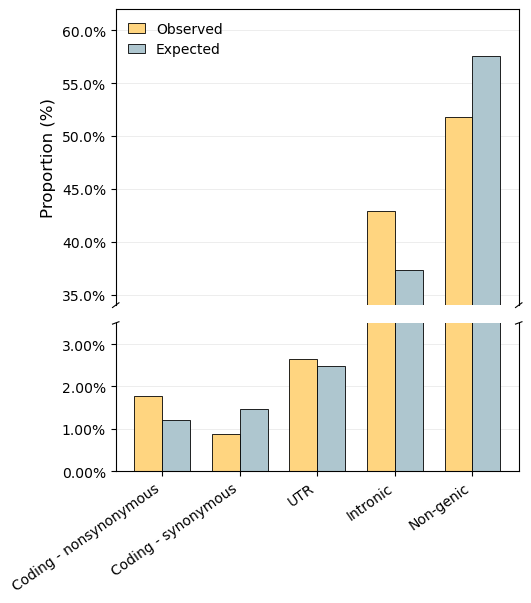

In [77]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

# --- Styling for publication ---
plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.linewidth": 0.8,
})

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, sharex=True,
    figsize=(5.2, 6),                        # slightly larger
    gridspec_kw={"height_ratios": [2.0, 1.0], "hspace": 0.08}  # more space between panels
)


x = np.arange(len(df_grouped))
bar_w = 0.36

# --- Bars on both axes ---
for ax in (ax_top, ax_bot):
    ax.bar(x, df_grouped["Proportion_observed"], width=bar_w,
           label="Observed", color="#FFD580", edgecolor="black", linewidth=0.6)
    ax.bar(x + bar_w, df_grouped["Proportion_expected"], width=bar_w,
           label="Expected", color="#AEC6CF", edgecolor="black", linewidth=0.6)

# --- Y-limits for broken axis ---
ax_top.set_ylim(0.34, 0.62)
ax_bot.set_ylim(0, 0.035)

# --- Clean frame with diagonal marks ---
ax_top.spines["bottom"].set_visible(False)
ax_bot.spines["top"].set_visible(False)
ax_top.tick_params(bottom=False, labelbottom=False)

d = 0.008  # size of diagonals
kwargs = dict(color="k", clip_on=False, linewidth=0.8)
ax_top.plot((-d, +d), (-d, +d), transform=ax_top.transAxes, **kwargs)
ax_top.plot((1 - d, 1 + d), (-d, +d), transform=ax_top.transAxes, **kwargs)
ax_bot.plot((-d, +d), (1 - d, 1 + d), transform=ax_bot.transAxes, **kwargs)
ax_bot.plot((1 - d, 1 + d), (1 - d, 1 + d), transform=ax_bot.transAxes, **kwargs)

# --- X labels only on bottom ---
ax_bot.set_xticks(x + bar_w/2)
ax_bot.set_xticklabels(df_grouped["EFFECT_grouped"], rotation=35, ha="right")

# --- Y axis formatting ---
ax_top.set_ylabel("Proportion (%)")
for ax in (ax_top, ax_bot):
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.grid(axis="y", linestyle="-", linewidth=0.4, alpha=0.4)
    ax.set_axisbelow(True)

# --- Legend ---
ax_top.legend(frameon=False, loc="upper left", ncol=1, handlelength=1.2)

# --- Significance stars ---
for i, p in enumerate(df_grouped["p_value_binomial_fdr"]):
    if p < 0.05:
        yobs = df_grouped.loc[i, "Proportion_observed"]
        yexp = df_grouped.loc[i, "Proportion_expected"]
        ymax = max(yobs, yexp)
        if ymax > ax_top.get_ylim()[0]:
            ax = ax_top
            gap = 0.012
        else:
            ax = ax_bot
            gap = 0.002
        ax.text(i + bar_w/2, ymax + gap, "*", ha="center", va="bottom", fontsize=20)

# --- Tight layout + save ---
plt.tight_layout()
fig.savefig(
    f"{ana_dir}/Figures/variant_effects_proportions_grouped_broken.png",
    dpi=600, bbox_inches="tight"
)
fig.savefig(
    f"{ana_dir}/Figures/variant_effects_proportions_grouped_broken.svg",
    bbox_inches="tight"
)
plt.show()

## Figure 3A Fishers combined score. manhatten plot

In [7]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
#import colorbrewer
import yaml
from matplotlib.backends.backend_pdf import PdfPages
out_dir = "/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/output/fst"
ana_dir = "/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex"

eu = os.path.expanduser
jn = os.path.join
ap = os.path.abspath

chrom_len = pd.read_csv('/scratch/antwerpen/grp/asvardal/projects/cichlid/reference/fAstCal1.2/GCA_900246225.3_fAstCal1.2_genomic_chromnames_mt.fa.fai',
                           sep='\t', usecols=[0,1], names=['chrom','len'], index_col=0).squeeze("columns")


def read_pop_fst(fn):
    fst_df = pd.read_csv(fn,sep='\t',index_col=[0,1]).dropna().squeeze("columns")
    fst_df.index = pd.MultiIndex.from_arrays([fst_df.index.droplevel(1),
                                                 (fst_df.index.droplevel(0)+(fst_df['BIN_END']-fst_df.index.droplevel(0))/2).astype(int)])
    return fst_df
    

def get_fst_comparions(callset_id, run_id, combinations):
    fst_df = []
    for pop1,pop2 in combinations:#itertools.combinations(places, 2):
        fst =  read_pop_fst(callset_id, run_id, pop1, pop2)
        fst_df.append(fst)
    fst_df = pd.concat(fst_df,axis=1) 
    fst_df = fst_df.reindex(chromosomes,level=0)
    return fst_df

def get_chrom_grid(chrom_lens, parent_gridelement=None):
    """
    subplot_spec is the parent gird
    """
    if parent_gridelement is None:
        parent_gridelement = mpl.gridspec.GridSpec(1, 1)[0] 
    gs = mpl.gridspec.GridSpecFromSubplotSpec(1, len(chrom_lens),
                                                     width_ratios=chrom_lens.astype(float)/sum(chrom_lens),
                                                                                 subplot_spec=parent_gridelement)
    return gs, parent_gridelement


def get_chrom_axes(grid=None,parent_gridelement=None,fig=None,
                      ylabel = "", plot_xlabels=True, color=None):
    """
    axes of the returned figure are the chromosomes 
    plus one global axes across all chromosomes
    """
    if plotfun is None:
        plotfun = plt.plot
    if grid is None:
        grid, parent_gridelement = get_chrom_grid(parent_gridelement=parent_gridelement)
    if fig is None:
        fig = plt.figure(1,figsize=(20,2))
    fig.subplots_adjust(wspace=0)
    #print color
    if color is None:
        print("changed to blue")
        color = mpl.rcParams['axes.color_cycle'][0]
    color = converter.to_rgb(color) 
    chroms = series.index.get_level_values(level=0).unique()
    for i,(chrom, gr) in enumerate(zip(chroms,grid)):
        if i == 0:
            ax = fig.add_subplot(gr)
        else:
            ax = fig.add_subplot(gr, sharey=ax)
            ax.set_yticks([])
        
        if i % 2 == 0:
            color1 = tuple(np.array(color)*0.6)
            if plot_xlabels:
                ax.set_xlabel('Chr'+chrom.rsplit("_")[1])
        else:
            color1 = color
        #print color1
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_color_cycle([color1])
    ylim = ax.get_ylim()
    #we could also get the parent element with gr.get_topmost_subplotspec()
    total_ax = fig.add_subplot(parent_gridelement)
    total_ax.set_frame_on(False)
    total_ax.spines['top'].set_visible(True)
    total_ax.set_ylim(ylim)
    total_ax.set_xticks([])
    if not ylabel and series.name is not None:
        ylabel = series.name
    total_ax.set_ylabel(ylabel,fontsize = 25)
    if plot_xlabels:
        total_ax.set_xlabel("Chromosomes",labelpad=25,fontsize = 25)
    return fig.get_axes()

converter =  mpl.colors.ColorConverter()
def plot_chrom_series(series,chrom_len,plotfun=None,grid=None,parent_gridelement=None,fig=None,
                      ylabel = "", plot_xlabels=True, color=None,title=None,rightlabel=None,**kwa):
    """

    chrom_len ... series or dict with chrom names as keys and chromosomes length as values
    axes of the returned figure are the chromosomes 
    plus one global axes across all chromosomes

    
    """
    if plotfun is None:
        plotfun = plt.plot
    if grid is None:
        grid, parent_gridelement = get_chrom_grid(chrom_lens=chrom_len,parent_gridelement=parent_gridelement)
    if fig is None:
        fig = plt.figure(1,figsize=(20,2))
    fig.subplots_adjust(wspace=0)
    #print color
    if color is None:
        color = 'blue'
    color = converter.to_rgb(color) 
    #chroms = series.index.get_level_values(level=0).unique()
    try: 
        chroms = chrom_len.index
    except AttributeError:
        chroms = chrom_len.keys()

    axes = {}
    for i,(chrom, gr) in enumerate(zip(chroms,grid)):
        #print chrom
        if i == 0:
            ax = fig.add_subplot(gr)
        else:
            ax = fig.add_subplot(gr, sharey=ax)
            ax.set_yticks([])

        axes.update({chrom:ax})
        
        if i % 2 == 0:
            color1 = tuple(np.array(color)*0.6)
            if plot_xlabels:
                ax.set_xlabel(chrom)
        else:
            color1 = color
        #print color1
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_xlim([0,chrom_len[chrom]])
       # if chrom == 'CAE3':
            #print series.ix[chrom].index.values[~np.isnan(series.ix[chrom].values)]
        try:
            chrom_series = series.loc[chrom]
        except KeyError:
            continue
        plotfun(chrom_series.index.values,chrom_series.values,'.',color=color1,rasterized=True,**kwa)
    ylim = ax.get_ylim()
    #we could also get the parent element with gr.get_topmost_subplotspec()
    #we don't share y here because otherwise the ticks are interdependent,
    #is there a way to turn tick on for only one of the shared axes?
    total_ax = fig.add_subplot(parent_gridelement) 
    axes.update({"total_ax" : total_ax})
    total_ax.set_frame_on(False)
    total_ax.spines['top'].set_visible(True)
    total_ax.set_ylim(ylim)
    total_ax.set_xticks([])
    if not ylabel and series.name is not None:
        ylabel = series.name
    total_ax.set_ylabel(ylabel,fontsize = 25)
    total_ax.set_yticks
    
    if plot_xlabels:
        total_ax.set_xlabel("Chromosomes",labelpad=25,fontsize = 25)
        
    if rightlabel is not None:
        ax2 = ax.twinx()
        axes.update({"right_ax":ax2})
        ax2.set_ylabel(rightlabel, color=color1,fontsize=25)
        ax2.set_yticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        
    if title is not None:
        plt.title(title)#, position=(0.5,1.02),va='bottom'

    return fig, axes, grid, parent_gridelement

In [157]:
def plotting_all_chrom(df,series, col):
    fig = plt.figure(1, figsize=(20,100))
    fig.clear()
    fs_all = []
    

    for i, chrom in enumerate(chromosomes):
        ax = fig.add_subplot(22,1,(i+1))
        df[series][chrom].plot(style='.', rasterized = True, color=col)
        ax.set_title(chrom)
        plt.ylabel(series)
        ax.set_xlim([0,chrom_len[chrom]])
        
    plt.tight_layout()
    
    return fig

In [152]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

/tmp/ipykernel_3209094/931246155.py:39: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  pp.close()


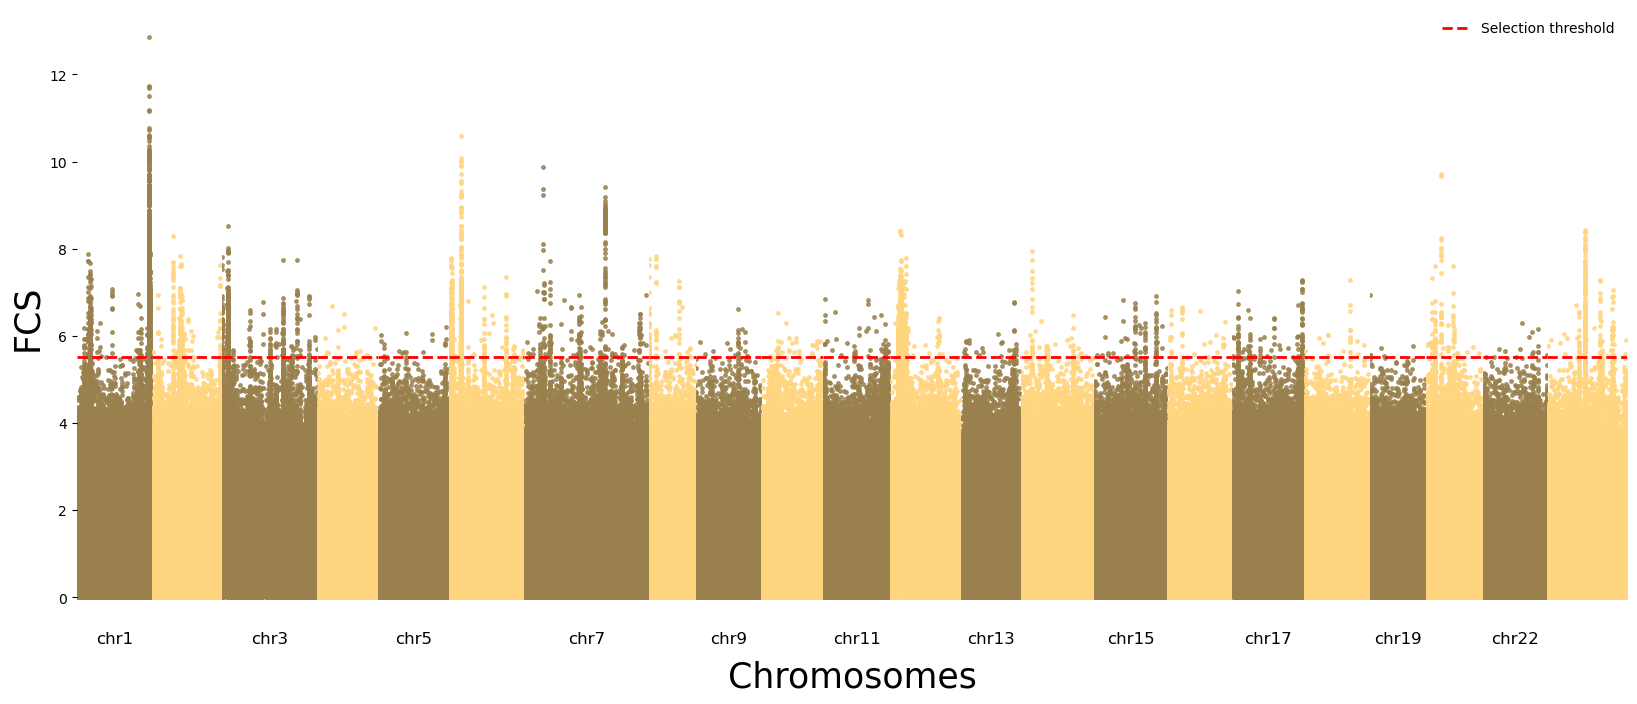

In [155]:
from matplotlib.lines import Line2D


pp = PdfPages(f'{ana_dir}/Figures/manhattenPlots/FCS4.pdf')

chromosomes = ['chr' + str(i) for i in range(1,24) if i != 21]

fig = plt.figure(figsize=(20,8))


fig, axes, grid, parent_gridelement = plot_chrom_series(merged_H_PBS['FCS'],
                                                        chrom_len.loc[chromosomes], alpha=0.8, fig=fig,
                                       grid=None, parent_gridelement=None, markersize=5, color='#FFD580')

# FCS simulation defined  threshold
threshold = 5.512684762384413


# Add horizontal line to all chromosome-specific axes
for chrom, ax in axes.items():
    if chrom in ['total_ax', 'right_ax']:
        continue  # Skip non-data axes

    # Draw dashed horizontal line
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2)
    
# Create custom legend handles
legend_elements = [
    Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Selection threshold')
]

# Add legend to the last chromosome axis
last_chrom = list(chromosomes)[-1]
axes[last_chrom].legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=False)

# plt.savefig(f'{ana_dir}/Figures/manhattenPlots/FCS4.pdf', format='pdf')
# plt.savefig(f"{ana_dir}/Figures/manhattenPlots/FCS4.svg", format="svg", bbox_inches="tight")
pp.close()

/tmp/ipykernel_3209094/291040323.py:9: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  pp.close()


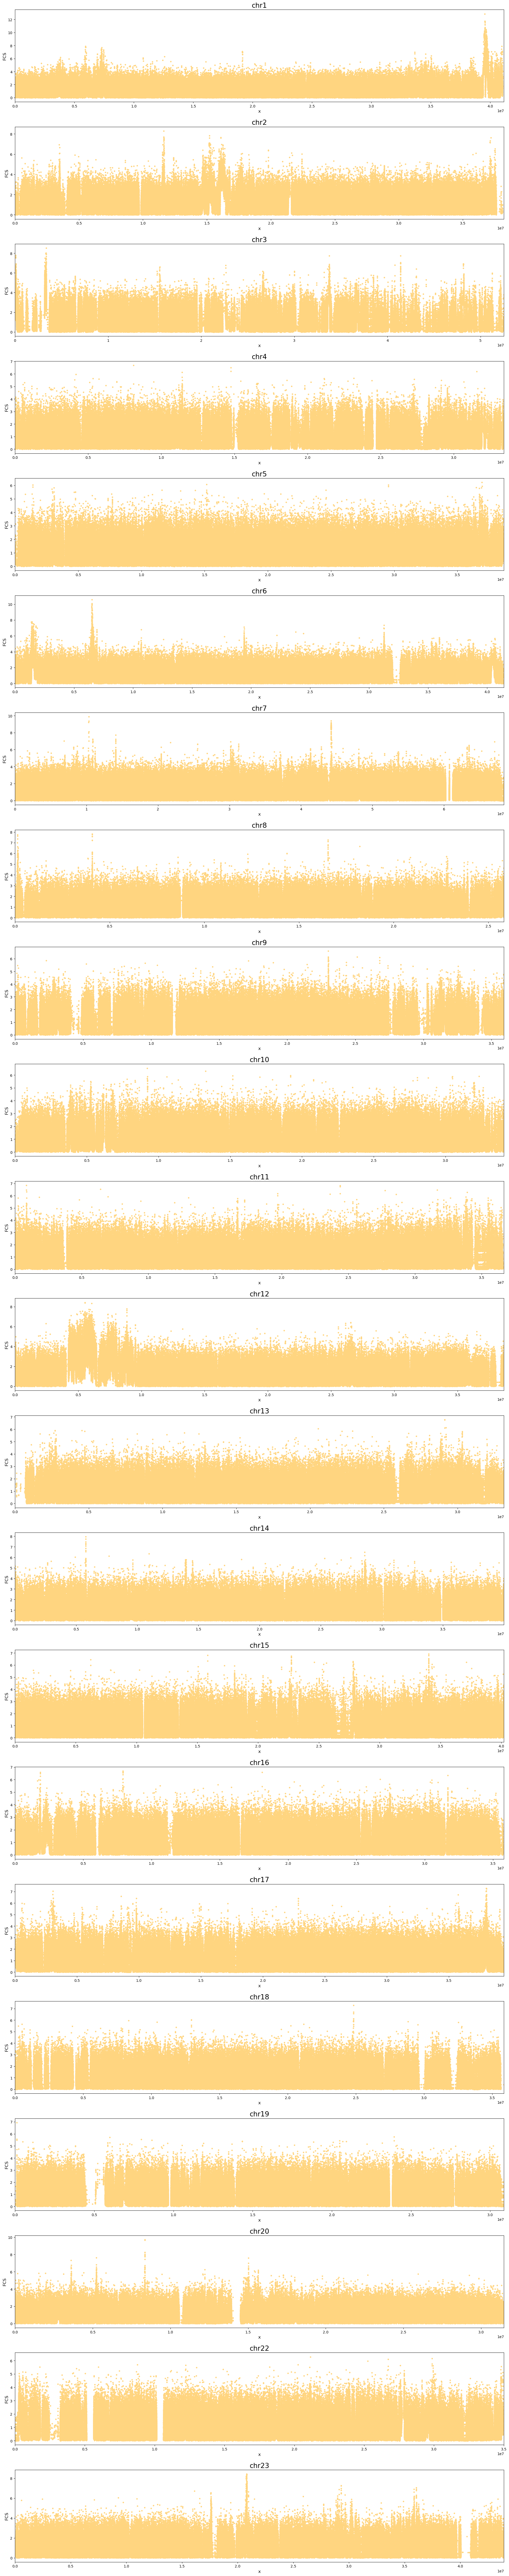

In [158]:
pp = PdfPages(f'{ana_dir}/Figures/manhattenPlots/FCS_all_chrom_seperate.pdf')

chromosomes = ['chr' + str(i) for i in range(1,24) if i != 21]

plotting_all_chrom(merged_H_PBS,'FCS','#FFD580')


# plt.savefig(pp, format='pdf')
pp.close()


## Figure 3B (& Supp figures) – Zoom plots for top regions

In [179]:
bcftools_regions_fn_ultra = f"{ana_dir}/Output/Genomic_features/candidate_regions10_chr:start-end.txt"
with open(bcftools_regions_fn_ultra, "r") as f:
    print(f.read())

chr1	39406357	39772713
chr2	11606365	11656365
chr3	3326518	3376518
chr6	6472995	6582963
chr7	10285777	10338291
chr7	44175985	44244688
chr12	5505879	5557210
chr12	6036511	6086511
chr20	8335345	8385356
chr23	20791821	20843857



Extended region frame to capture entire peak

In [339]:
from matplotlib.ticker import AutoLocator, FuncFormatter
import matplotlib as mpl

def plot_multi_zoom_overview(
    df, series, chrom, start, end,
    *,
    col="#FFD580",
    gtf_df=None,
    threshold=None,
    chrom_order=None,
    gap=1_000_000,
    pdf_path_base=None,
    # Extra zooms
    extra_series=None,
    extra_thresholds=None,
    extra_colors=None,
    # Layout
    base_fig_height=6.5,
    lane_height_inch=0.25,
    zoom_height_inch=2.4,
    overview_height_inch=2.0,
    exon_box_height=0.08,
    # ---- FONT CONTROLS ----
    font_scale=1.6,          # single knob to make *everything* larger
    title_size=None,         # override (otherwise derived from font_scale)
    axis_label_size=None,
    tick_label_size=None,
    gene_label_size=None,
    legend_size=None,
    # De-emphasis styling
    main_markersize=3.5,
    extra_markersize=2.2,
    main_alpha=0.95,
    extra_alpha=0.6,
    extra_greyscale=True,
):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.colors import to_rgb

    # --- Publication-friendly vector text in PDFs ---
    mpl.rcParams.update({
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })

    # ---- Derive font sizes from a single knob ----
    # Baselines chosen to look good in print; adjust if you like.
    _base = {
        "title": 14,
        "axis": 12,
        "tick": 10,
        "gene": 9,
        "legend": 11,
    }
    FS = {
        "title": int(round((title_size or _base["title"] * font_scale))),
        "axis":  int(round((axis_label_size or _base["axis"] * font_scale))),
        "tick":  int(round((tick_label_size or _base["tick"] * font_scale))),
        "gene":  int(round((gene_label_size or _base["gene"] * font_scale))),
        "legend":int(round((legend_size or _base["legend"] * font_scale))),
    }

    # helper to apply tick sizes to an axis
    def _ticks(ax):
        ax.tick_params(axis="both", which="major", labelsize=FS["tick"])
        ax.tick_params(axis="both", which="minor", labelsize=max(FS["tick"] - 1, 1))

    # ---------- checks ----------
    if series not in df.columns:
        raise ValueError(f"{series!r} not found in df columns.")
    extra_series = list(extra_series) if extra_series else []
    for s in extra_series:
        if s not in df.columns:
            raise ValueError(f"extra_series column {s!r} not found in df.")
    multi_index = hasattr(df.index, "nlevels") and df.index.nlevels >= 2
    if not multi_index and chrom is None:
        raise ValueError("Single-chromosome DataFrame detected. Please pass chrom='chrX'.")

    # ---------- helper: overview table (MultiIndex only) ----------
    def _build_overview_table(df, series, chrom_order, gap):
        chr_name, pos_name = df.index.names[:2]
        if chr_name is None: chr_name = "chrom"
        if pos_name is None: pos_name = "pos"
        ov = df[[series]].reset_index()
        if chr_name not in ov.columns or pos_name not in ov.columns:
            chr_name = chr_name if chr_name in ov.columns else "level_0"
            pos_name = pos_name if pos_name in ov.columns else "level_1"
        if chrom_order is None:
            chrom_order = list(pd.unique(ov[chr_name]))
        cats = pd.Categorical(ov[chr_name],
                              categories=[c for c in chrom_order if c in set(ov[chr_name])],
                              ordered=True)
        ov["_chrom"] = cats
        offsets, running = {}, 0
        for c in cats.categories:
            m = ov[chr_name] == c
            if not m.any():
                continue
            max_pos = int(ov.loc[m, pos_name].max())
            offsets[c] = running
            running += max_pos + gap
        ov["_x"] = ov[pos_name] + ov[chr_name].map(offsets)
        return ov, chr_name, pos_name, cats, offsets

    if multi_index:
        ov, chr_name, pos_name, cats, offsets = _build_overview_table(df, series, chrom_order, gap)
    else:
        ov = chr_name = pos_name = cats = offsets = None

    # ---------- collect genes ----------
    genes = []
    if gtf_df is not None:
        pad = max(1, int((end - start) * 0.01))
        sub = gtf_df[(gtf_df["seqname"] == chrom) &
                     (gtf_df["end"] >= start - pad) &
                     (gtf_df["start"] <= end + pad)].copy()
        if not sub.empty:
            # choose grouping key
            by_key = "gene_id" if "gene_id" in sub.columns else ("gene_name" if "gene_name" in sub.columns else None)
            if by_key is None:
                by_key = sub.columns[0]  # fallback to something stable
    
            for gid, gsub in sub.groupby(by_key):
                gr = gsub[gsub["feature"] == "gene"]
                if gr.empty:
                    continue
    
                gs, ge = int(gr["start"].min()), int(gr["end"].max())
    
                # prefer non-empty gene_name, else gene_id, per gene
                if "gene_name" in gr.columns and "gene_id" in gr.columns:
                    nm_series = gr["gene_name"].astype(str).str.strip()
                    if (nm_series != "").any() and gr["gene_name"].notna().any():
                        nm_candidates = gr.loc[gr["gene_name"].notna() & (nm_series != ""), "gene_name"]
                        nm = str(nm_candidates.iloc[0])
                    else:
                        nm = str(gr["gene_id"].iloc[0])
                elif "gene_name" in gr.columns:
                    nm = str(gr["gene_name"].astype(str).str.strip().replace("", pd.NA).dropna().iloc[0])
                elif "gene_id" in gr.columns:
                    nm = str(gr["gene_id"].iloc[0])
                else:
                    nm = "unknown"
    
                ex = (
                    gsub[gsub["feature"] == "exon"][["start", "end"]]
                    .astype(int)
                    .sort_values("start")
                    .to_numpy()
                )
                genes.append({"name": nm, "start": gs, "end": ge, "exons": ex})
    n_genes = len(genes) + 1  # one empty lane on top
    n_extra = len(extra_series)

    # ---------- dynamic height ----------
    total_inches = (n_genes * lane_height_inch) + (10 + n_extra) * zoom_height_inch + overview_height_inch
    fig_height = base_fig_height + n_genes * lane_height_inch + n_extra * (zoom_height_inch * 0.5)
    fig = plt.figure(figsize=(12, fig_height), constrained_layout=True)

    # Panel order (top→bottom): Genes, Main zoom, Extras..., Overview
    ratios = []
    ratios.append((n_genes * lane_height_inch) / total_inches if n_genes > 0 else 0.0001)  # genes
    ratios.append(zoom_height_inch / total_inches)                                          # main
    for _ in range(n_extra): ratios.append(zoom_height_inch / total_inches)                # extras
    ratios.append(overview_height_inch / total_inches)                                     # overview
    gs = fig.add_gridspec(nrows=len(ratios), ncols=1, height_ratios=ratios)

    # Axes creation with shared x across genes + all zoom panels
    ax_genes = fig.add_subplot(gs[0, 0]) if n_genes > 0 else None
    prev_share = ax_genes if n_genes > 0 else None
    ax_main = fig.add_subplot(gs[1, 0], sharex=prev_share if prev_share is not None else None)
    prev_share = ax_main
    ax_extras = []
    for i in range(n_extra):
        ax = fig.add_subplot(gs[2 + i, 0], sharex=prev_share)
        ax_extras.append(ax)
        prev_share = ax
    ax_over = fig.add_subplot(gs[-1, 0])

    # ---------- helpers ----------
    mb_formatter = FuncFormatter(lambda x, _: f"{x/1e6:.2f} Mb")

    def _get_series_slice(series_name):
        if multi_index:
            return df[series_name].xs(chrom, level=0)
        else:
            return df[series_name]

    def _plot_zoom_axis(ax, series_name, color, markersize, alpha, show_xtick_labels, thr, ylabel):
        ser_chr = _get_series_slice(series_name)
        ser_zoom = ser_chr.loc[start:end]
        ax.plot(ser_zoom.index, ser_zoom.values, ".", rasterized=True,
                color=color, markersize=markersize, alpha=alpha)
        ax.set_xlim(start, end)
        if ylabel: ax.set_ylabel(ylabel, fontsize=FS["axis"])
        if thr is not None:
            ax.axhline(thr, ls="--", lw=1.2, color="red", alpha=0.7)
        ax.tick_params(bottom=show_xtick_labels, labelbottom=show_xtick_labels)
        ax.xaxis.set_major_locator(AutoLocator())
        ax.xaxis.set_major_formatter(mb_formatter)
        _ticks(ax)
        ax.spines["top"].set_visible(False)

    # ---------- genes panel ----------
    if ax_genes is not None and n_genes > 1:
        import matplotlib.patches as patches
        lane_h = 1.0 / n_genes
        for lane, gene in enumerate(sorted(genes, key=lambda g: (g["start"], g["end"])), start=1):
            y = 1.0 - (lane + 0.5) * lane_h
            ax_genes.plot([gene["start"], gene["end"]], [y, y], lw=1.2, color="black", alpha=0.75, zorder=1)
            half_h = exon_box_height * 2 * lane_h * 3
            for s, e in gene["exons"]:
                ax_genes.add_patch(
                    patches.Rectangle((int(s), y - half_h), int(e) - int(s), 2*half_h,
                                      facecolor="black", edgecolor="black", lw=0.9, zorder=2)
                )
            ax_genes.text((gene["start"] + gene["end"]) / 2.0, y + half_h + lane_h*0.10,
                          gene["name"], ha="center", va="bottom", fontsize=FS["gene"],
                          bbox=dict(facecolor="white", edgecolor="none", alpha=0.9, pad=0.2),
                          clip_on=True, zorder=3)
        ax_genes.set_xlim(start, end)
        ax_genes.set_ylim(0.0, 1.0)
        ax_genes.set_yticks([])
        ax_genes.tick_params(bottom=False, labelbottom=False)
        ax_genes.spines["bottom"].set_visible(False)
        _ticks(ax_genes)

    # ---------- main zoom ----------
    _plot_zoom_axis(ax_main, series, col, main_markersize, main_alpha,
                    show_xtick_labels=(n_extra == 0),
                    thr=threshold, ylabel=series)

    # ---------- extra zooms ----------
    if extra_colors is None:
        if extra_greyscale:
            extra_colors = ["0.3"] * n_extra
        else:
            base = np.array(to_rgb(col))
            extra_colors = [tuple(base * 0.6)] * n_extra

    for i, (ax, sname) in enumerate(zip(ax_extras, extra_series)):
        show_ticks = (i == len(ax_extras) - 1)
        thr_val = None
        if isinstance(extra_thresholds, dict):
            thr_val = extra_thresholds.get(sname, None)
        elif isinstance(extra_thresholds, (list, tuple)):
            thr_val = extra_thresholds[i] if i < len(extra_thresholds) else None
        _plot_zoom_axis(ax, sname, extra_colors[i], extra_markersize, extra_alpha,
                        show_xtick_labels=show_ticks, thr=thr_val, ylabel=sname)

    # ---------- overview ----------
    if multi_index:
        base = np.array(to_rgb(col)); light = tuple(base); dark = tuple(base * 0.6)
        for i, c in enumerate(cats.categories):
            if c not in offsets: continue
            m = ov[chr_name] == c
            if not m.any(): continue
            ax_over.scatter(ov.loc[m, "_x"], ov.loc[m, series], s=6, rasterized=True,
                            color=(dark if (i % 2) else light))
        if threshold is not None:
            ax_over.axhline(threshold, ls="--", lw=1.2, color="red", alpha=0.7)

        ticks, labels = [], []
        for c in cats.categories:
            if c not in offsets: continue
            m = ov[chr_name] == c
            if not m.any(): continue
            x_min = ov.loc[m, "_x"].min(); x_max = ov.loc[m, "_x"].max()
            ticks.append((x_min + x_max) / 2); labels.append(str(c))
        if ticks:
            last_chr = cats.categories[-1]
            if last_chr in offsets:
                max_pos_last = ov.loc[ov[chr_name] == last_chr, "_x"].max()
                ax_over.set_xlim(ov["_x"].min(), max_pos_last + gap)
            ax_over.set_xticks(ticks)
            ax_over.set_xticklabels(labels, fontsize=FS["tick"])
        ax_over.set_ylabel(series, fontsize=FS["axis"])
        ax_over.set_xlabel("Chromosome", fontsize=FS["axis"])
        _ticks(ax_over)
    else:
        ax_over.axvspan(start, end, alpha=0.05, color="blue", lw=0)
        ser_over = df[series]
        ax_over.plot(ser_over.index, ser_over.values, ".", color=col, markersize=3.5, rasterized=True)
        ax_over.axvline(start, color="blue", lw=0.8, alpha=0.5)
        ax_over.axvline(end,   color="blue", lw=0.8, alpha=0.5)
        if threshold is not None:
            ax_over.axhline(threshold, ls="--", lw=1.2, color="red", alpha=0.7)
        x_min, x_max = float(np.min(ser_over.index)), float(np.max(ser_over.index))
        ax_over.set_xlim(x_min, x_max)
        ax_over.set_ylabel(series, fontsize=FS["axis"])
        ax_over.set_xlabel(f"{chrom} position (Mb)", fontsize=FS["axis"])
        ax_over.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e6:.1f} Mb"))
        _ticks(ax_over)

    # ---------- optional figure title / legend sizing ----------
    # (Add a title wherever you need it, using FS["title"])
    for leg in fig.legends or []:
        for txt in leg.get_texts():
            txt.set_fontsize(FS["legend"])

    # ---------- save ----------
    if pdf_path_base:
        base_path = f"{pdf_path_base}/zoom_multi_{chrom}_{start}_{end}"
        fig.savefig(base_path + ".pdf", bbox_inches="tight")
        fig.savefig(base_path + ".svg", bbox_inches="tight")

    return fig

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 49 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'L', 'M', 'N', 'P', 'R', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 40, 41, 42, 43, 47, 48, 49, 51, 53, 54, 66, 68, 69, 70, 71, 72, 73, 74, 7

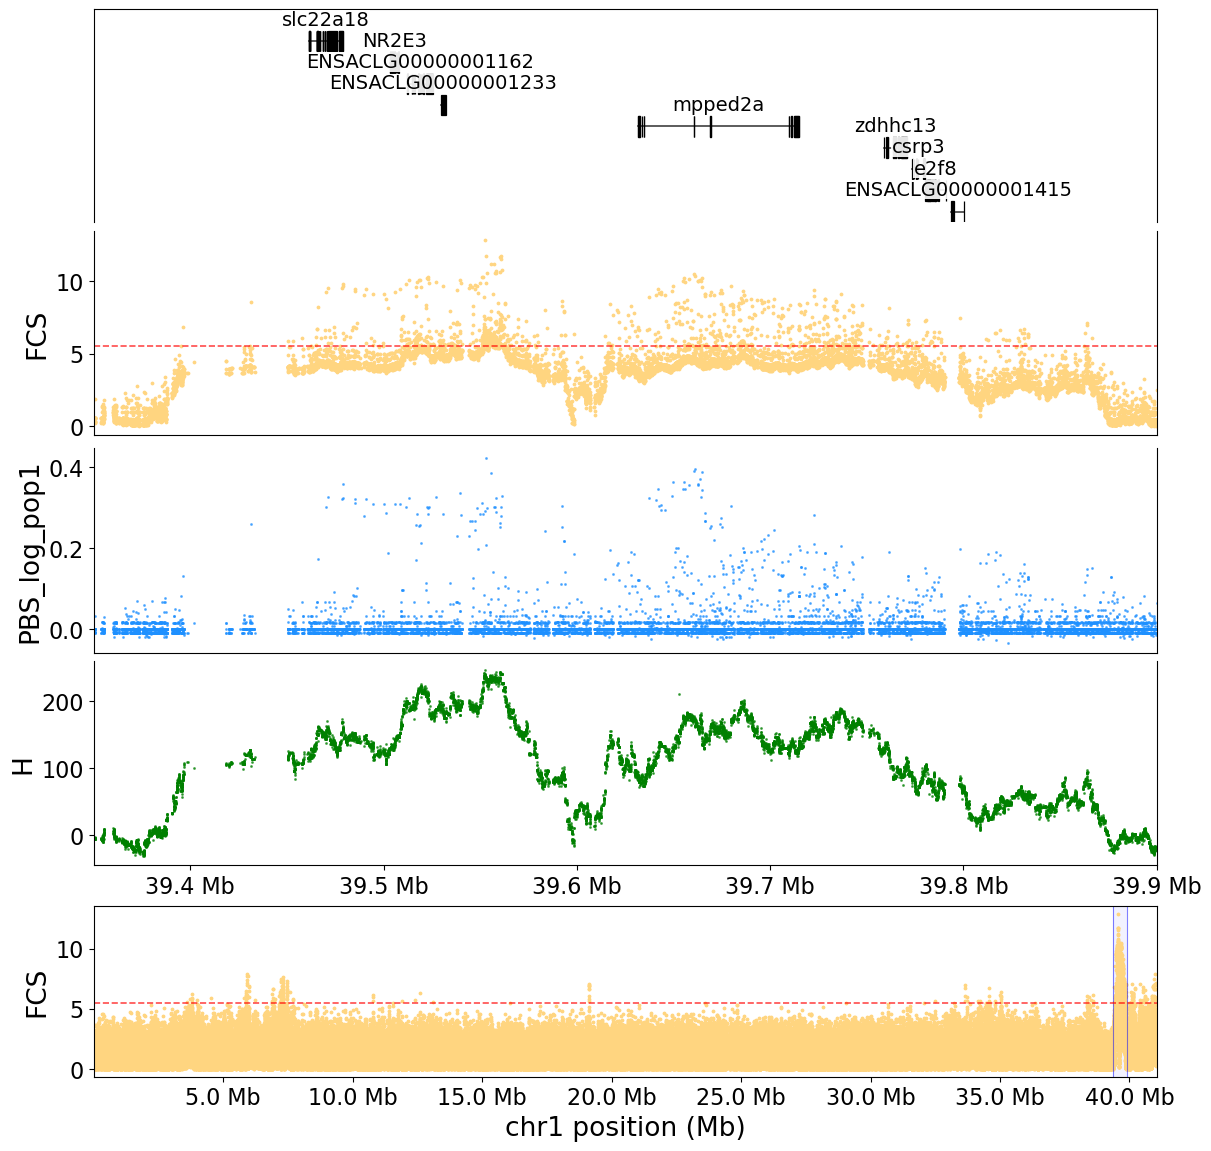

In [223]:
# Figure 3B Large chr1 region
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr1'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr1', start=39350000, end=39900000, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

### create a zoom plot for each of the top windows for supplement

rerun a few steps for quick reference

In [326]:
bcftools_regions_fn_ultra = f"{ana_dir}/Output/Genomic_features/candidate_regions10_chr:start-end.txt"
with open(bcftools_regions_fn_ultra, "r") as f:
    print(f.read())

chr1	39406357	39772713
chr2	11606365	11656365
chr3	3326518	3376518
chr6	6472995	6582963
chr7	10285777	10338291
chr7	44175985	44244688
chr12	5505879	5557210
chr12	6036511	6086511
chr20	8335345	8385356
chr23	20791821	20843857



In [335]:
#TSV from previous step
tsv_snpeff_ultra = f"{ana_dir}/Output/Genomic_features/anno_effect_per_snp_10candidate_regions.txt"

ann_candidate_regions = pd.read_csv(tsv_snpeff_ultra, sep = '\t')


# Some variants have more than one annotated effect. Rearrange to have one effect per row and remove duplicate rows.
ann_candidate_regions = ann_candidate_regions.set_index(['CHROM', 'POS','REF','ALT']).apply(lambda x: x.str.split(',').explode()).reset_index().drop_duplicates(subset=None, keep='first', inplace=False)

ann_candidate_regions['chr:pos'] = [f'{c}:{p}' for c, p in list(zip(ann_candidate_regions['CHROM'],ann_candidate_regions['POS']))]
ann_candidate_regions = ann_candidate_regions.replace(r"’", r'', regex=True)
ann_candidate_regions = ann_candidate_regions.replace(r"‘", r'', regex=True)

ann_candidate_regions_wo_intergeneic = ann_candidate_regions[ann_candidate_regions['ANN[*].EFFECT'] != 'intergenic_region']


In [337]:
gene_list = ann_candidate_regions_wo_intergeneic[ann_candidate_regions_wo_intergeneic['CHROM'] == 'chr2']['ANN[*].GENE']

symbol_list_genes = []
for g in list(gene_list):
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

In [338]:
unique_symbols

['ENSACLG00000016851']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'L', 'M', 'N', 'P', 'S', 'b', 'c', 'eight', 'five', 'four', 'g', 'h', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38, 40, 41, 42, 43, 47, 48, 49, 51, 54, 66, 69, 70, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87]
INFO:fontTools.subset:Closed gly

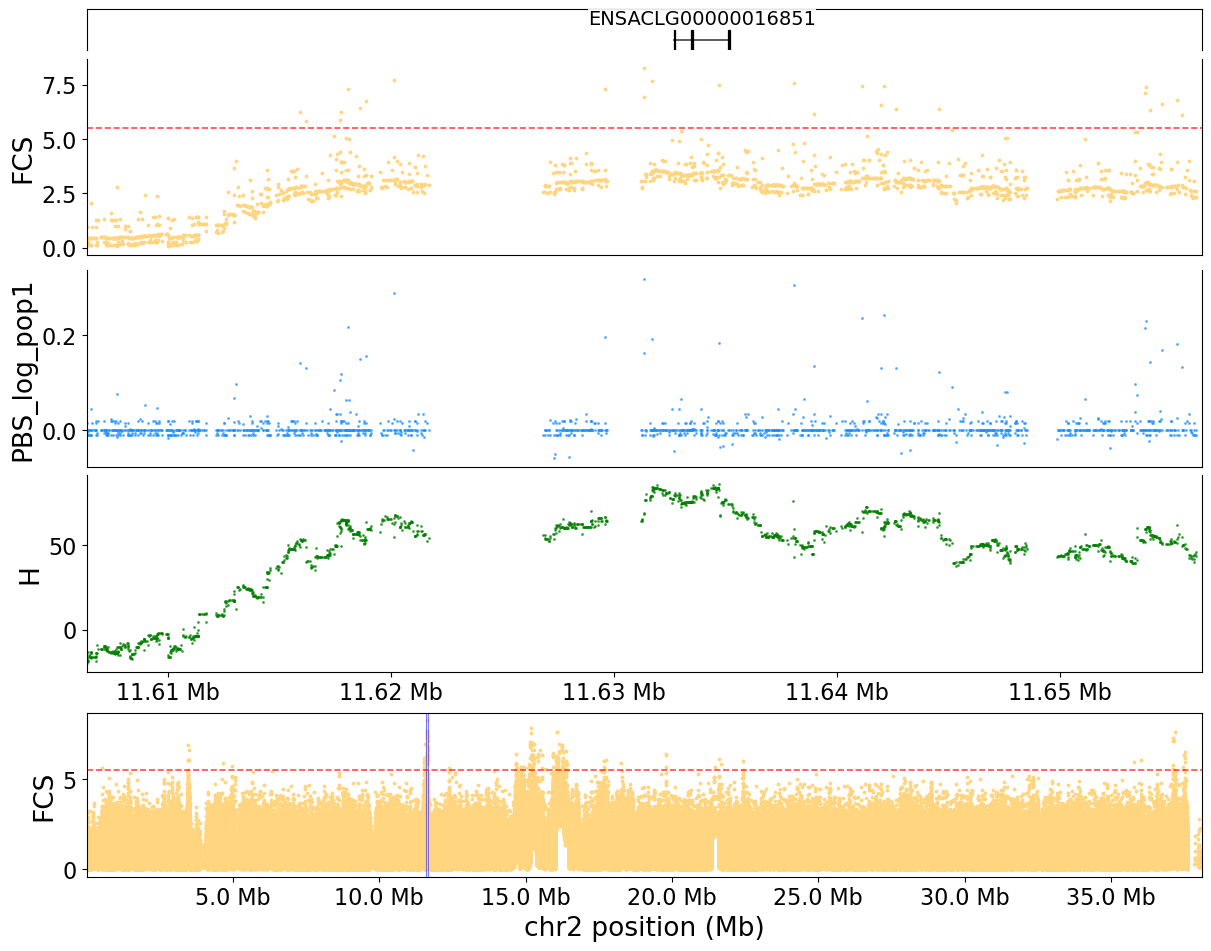

In [340]:
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr2'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr2', start=11606365, end=11656365, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

In [343]:
gene_list = ann_candidate_regions_wo_intergeneic[ann_candidate_regions_wo_intergeneic['CHROM'] == 'chr3']['ANN[*].GENE']

symbol_list_genes = []
for g in list(gene_list):
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

unique_symbols

['ANK2', 'ENSACLG00000009480']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'S', 'b', 'c', 'eight', 'five', 'four', 'g', 'h', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 40, 41, 42, 43, 46, 47, 48, 49, 51, 54, 66, 69, 70, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87]
INFO:fontTo

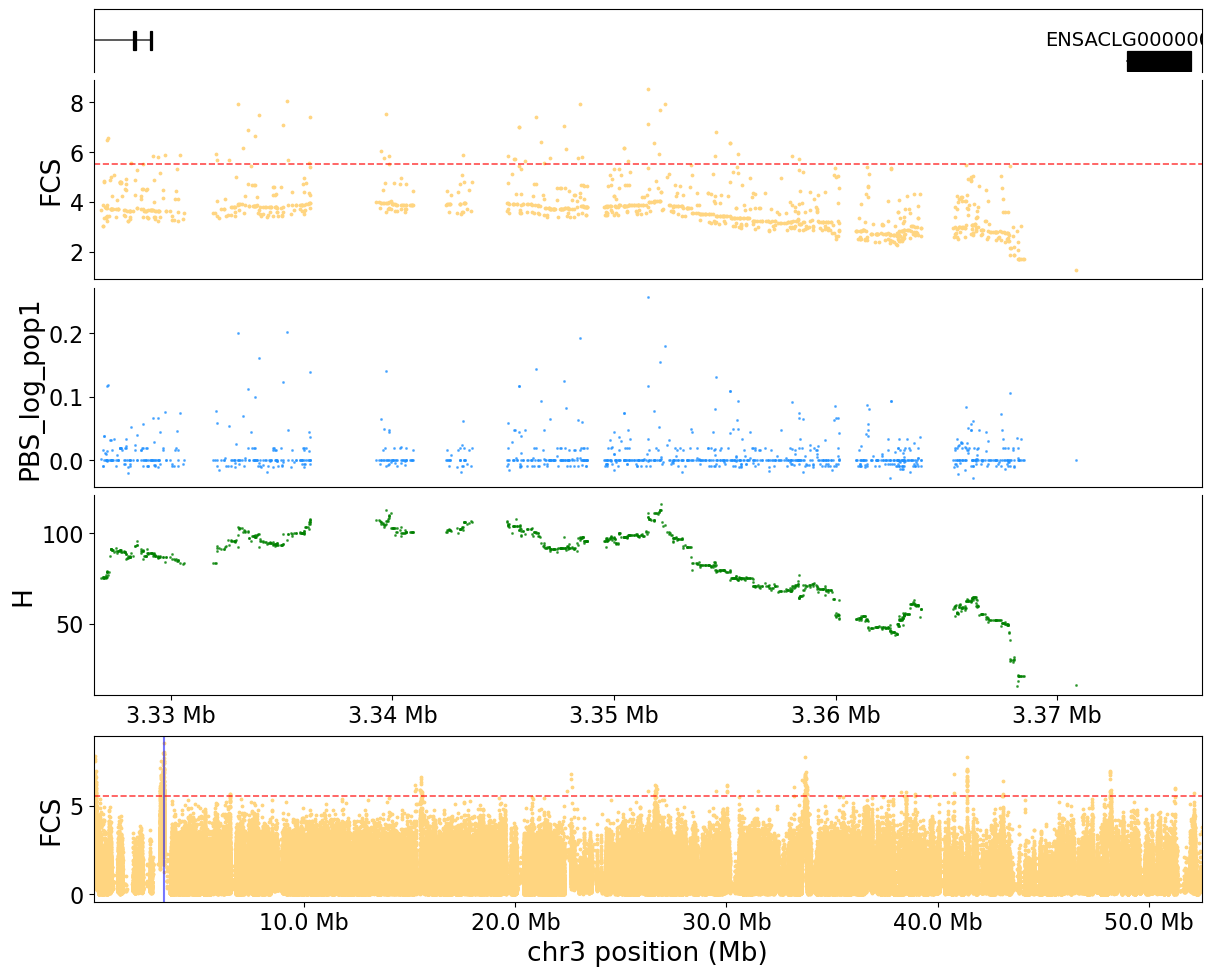

In [341]:
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr3'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr3', start=3326518, end=3376518, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

In [345]:
gene_list = ann_candidate_regions_wo_intergeneic[ann_candidate_regions_wo_intergeneic['CHROM'] == 'chr6']['ANN[*].GENE']

symbol_list_genes = []
for g in list(gene_list):
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

unique_symbols

['ENSACLG00000013470']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'L', 'M', 'N', 'P', 'S', 'b', 'c', 'eight', 'five', 'four', 'g', 'h', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38, 40, 41, 42, 43, 47, 48, 49, 51, 54, 66, 69, 70, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87]
INFO:fontTools.subset:Closed gly

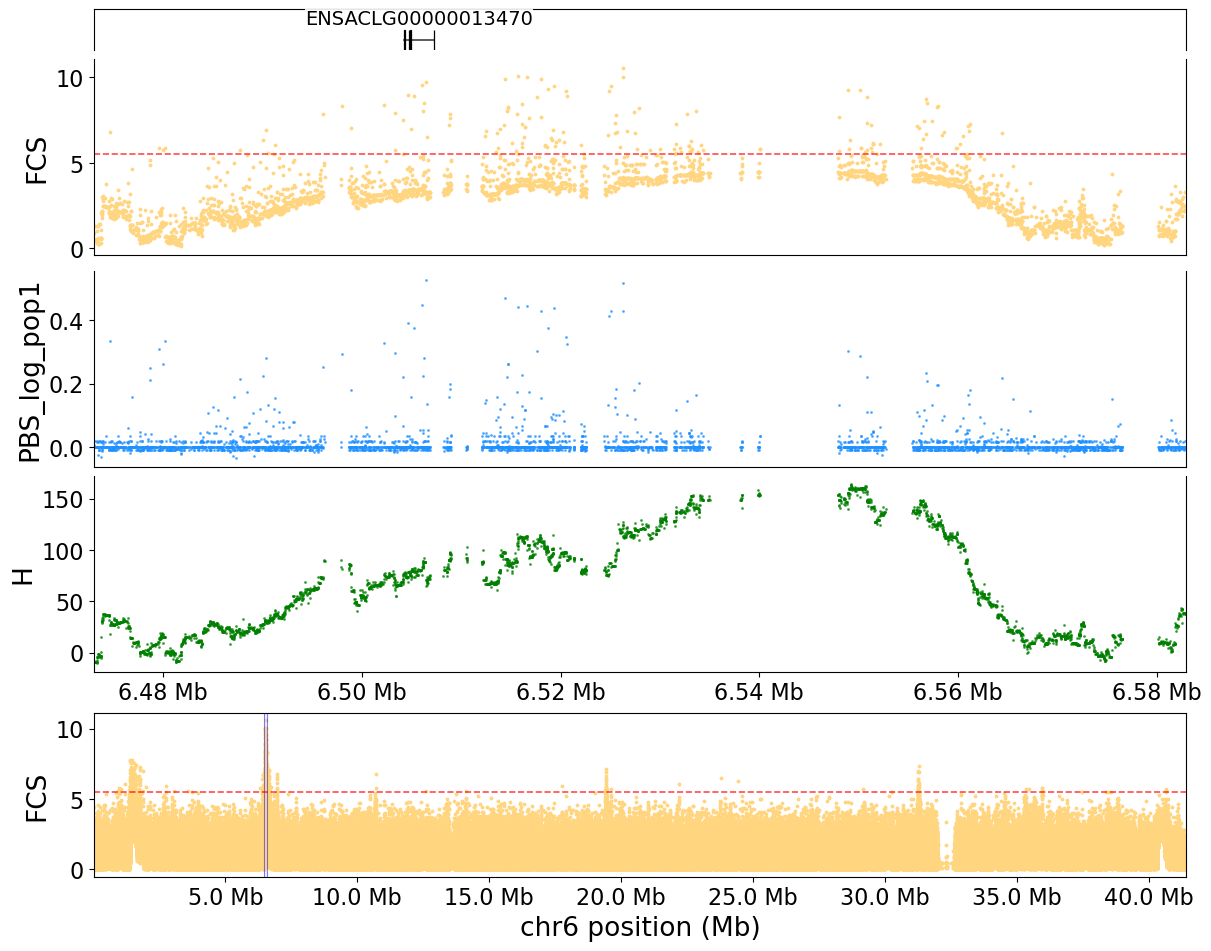

In [344]:
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr6'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr6', start=6472995, end=6582963, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

In [ ]:
gene_list = ann_candidate_regions_wo_intergeneic[ann_candidate_regions_wo_intergeneic['CHROM'] == 'chr7']['ANN[*].GENE']

symbol_list_genes = []
for g in list(gene_list):
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

unique_symbols

['si:dkey-12e7.4',
 'ENSACLG00000021888',
 'ENSACLG00000021917',
 'ENSACLG00000022020',
 'ENSACLG00000022038',
 'kitlga']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 49 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'L', 'M', 'N', 'P', 'S', 'b', 'c', 'colon', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 36, 37, 38, 40, 41, 42, 43, 47, 48, 49, 51, 54, 66, 69, 70, 71, 

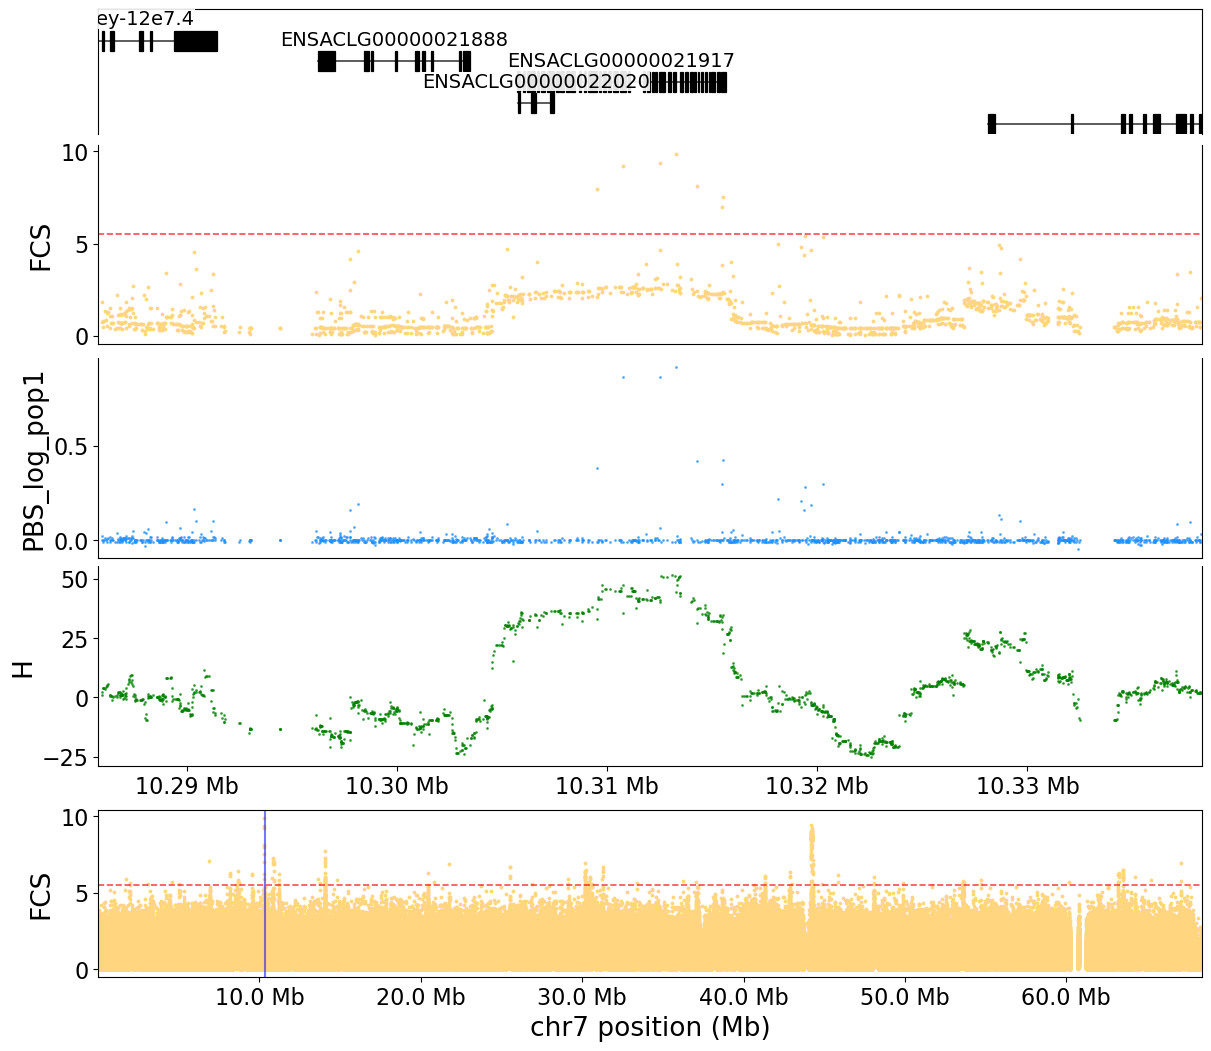

In [346]:
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr7'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr7', start=10285777, end=10338291, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'F', 'H', 'M', 'P', 'S', 'a', 'b', 'c', 'eight', 'five', 'four', 'g', 'h', 'i', 'k', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 37, 38, 41, 43, 48, 51, 54, 66, 68, 69, 70, 74, 75, 76, 78, 79, 81, 82, 83, 85, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'M

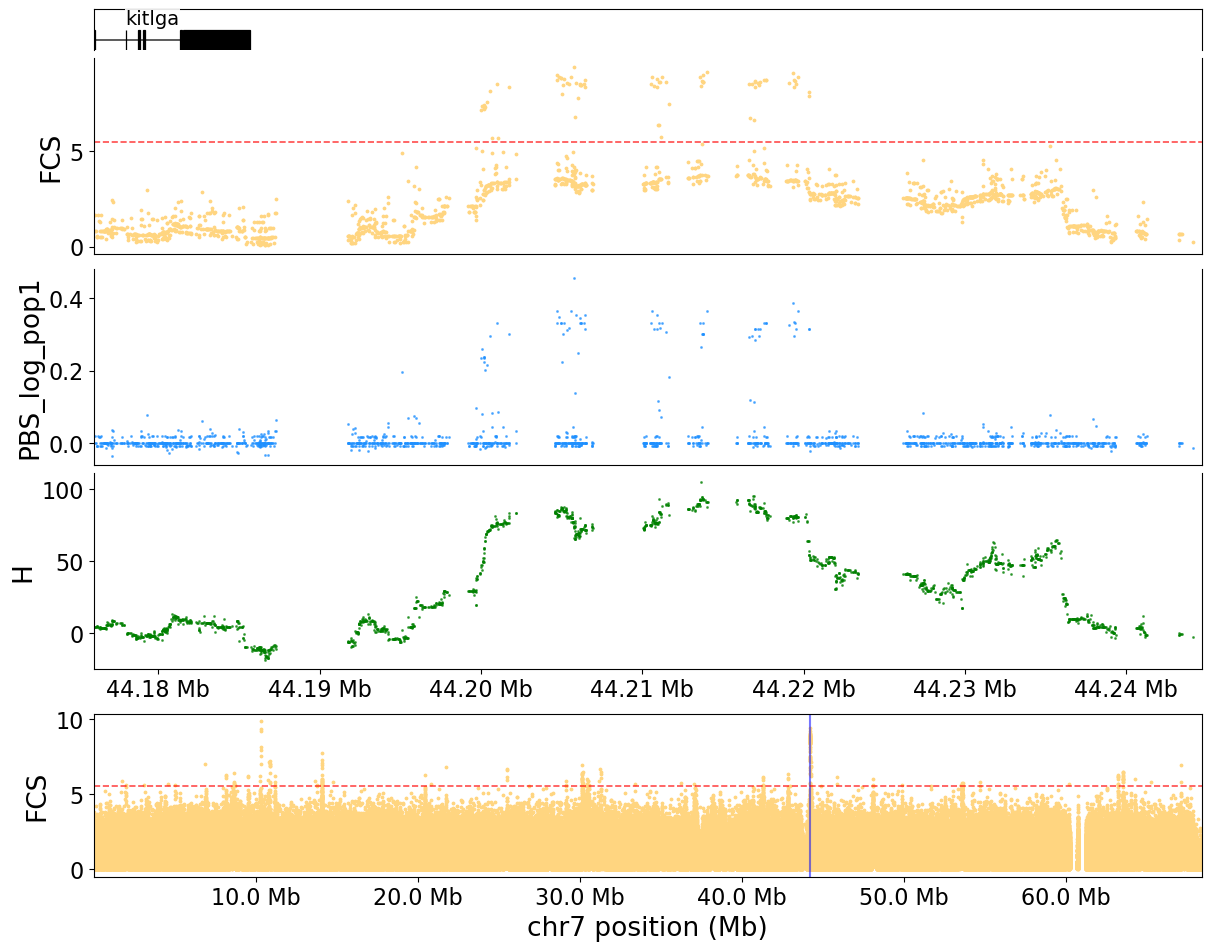

In [347]:
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr7'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr7', start=44175985, end=44244688, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

In [357]:
gene_list = ann_candidate_regions_wo_intergeneic[ann_candidate_regions_wo_intergeneic['CHROM'] == 'chr12']['ANN[*].GENE']

symbol_list_genes = []
for g in list(gene_list):
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

unique_symbols

['kat6a', 'ENSACLG00000003998', 'tbx1', 'gnb1l']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'L', 'M', 'N', 'P', 'S', 'a', 'b', 'c', 'eight', 'five', 'four', 'g', 'h', 'i', 'k', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 40, 41, 42, 43, 47, 48, 49, 51, 54, 66, 68, 69, 70, 74, 75, 76, 78, 79, 81, 82, 83, 85, 86, 87]
IN

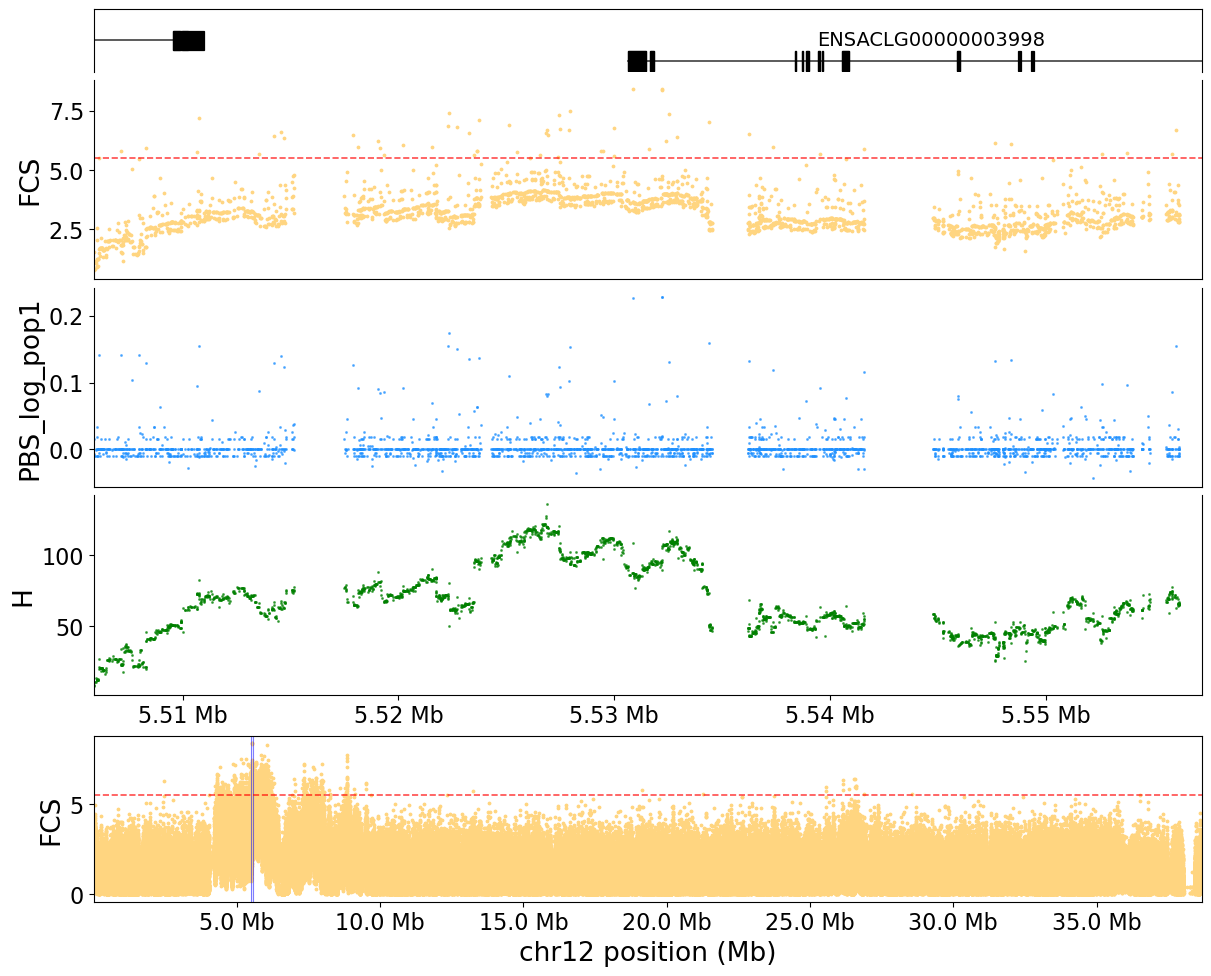

In [348]:
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr12'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr12', start=5505879, end=5557210, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 37 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'F', 'H', 'M', 'P', 'S', 'b', 'c', 'eight', 'five', 'four', 'g', 'h', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 37, 38, 41, 43, 48, 51, 54, 66, 69, 70, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87, 91]
INFO:fontTools.subset:Closed glyph list over 'MATH': 43 glyphs after

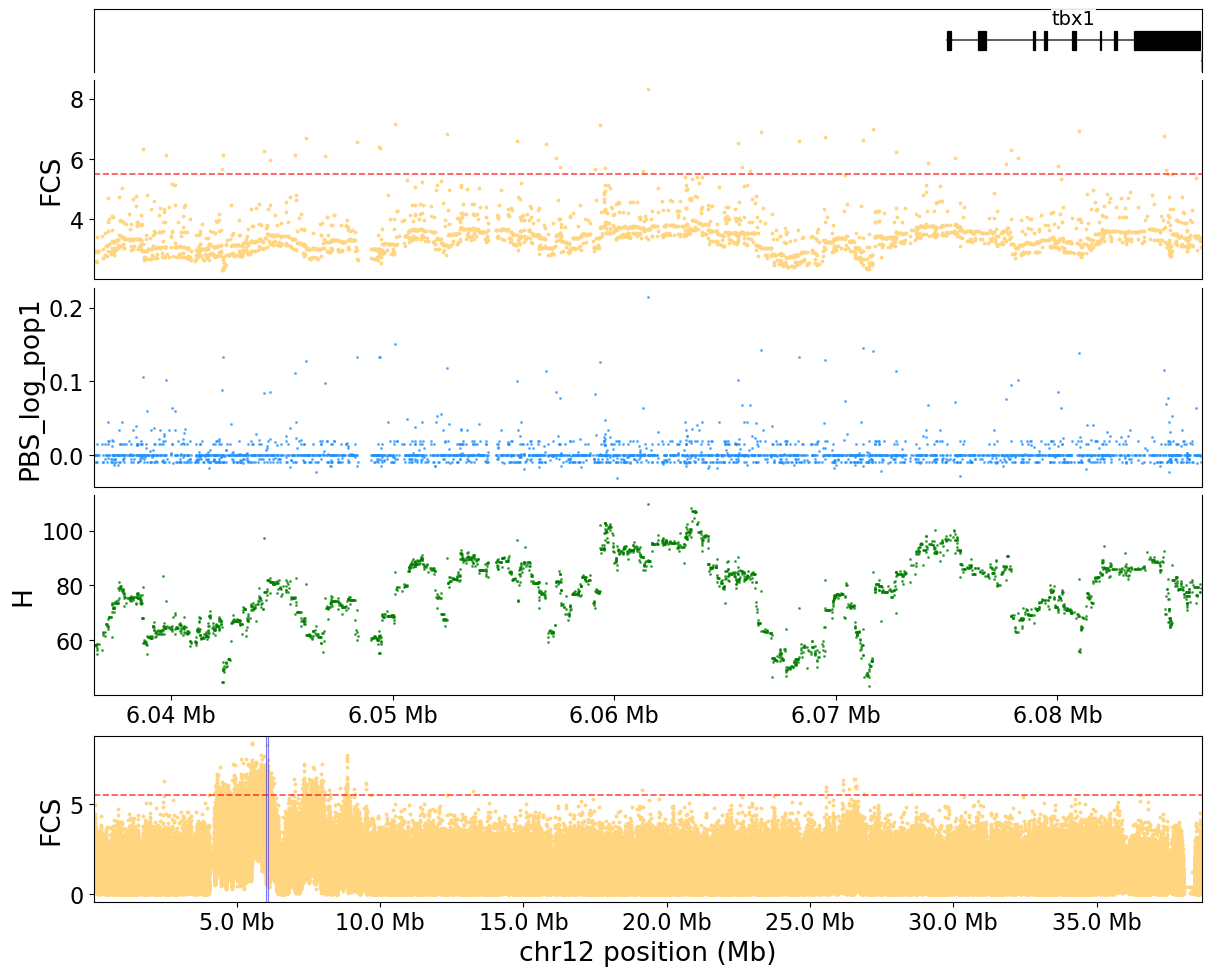

In [349]:
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr12'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr12', start=6036511, end=6086511, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

In [358]:
gene_list = ann_candidate_regions_wo_intergeneic[ann_candidate_regions_wo_intergeneic['CHROM'] == 'chr20']['ANN[*].GENE']

symbol_list_genes = []
for g in list(gene_list):
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

unique_symbols

['ENSACLG00000024047', 'MAGI1']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'P', 'S', 'b', 'c', 'eight', 'five', 'four', 'g', 'h', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38, 40, 41, 42, 43, 44, 47, 48, 49, 51, 54, 66, 69, 70, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87]
INFO:fontTools.subset:C

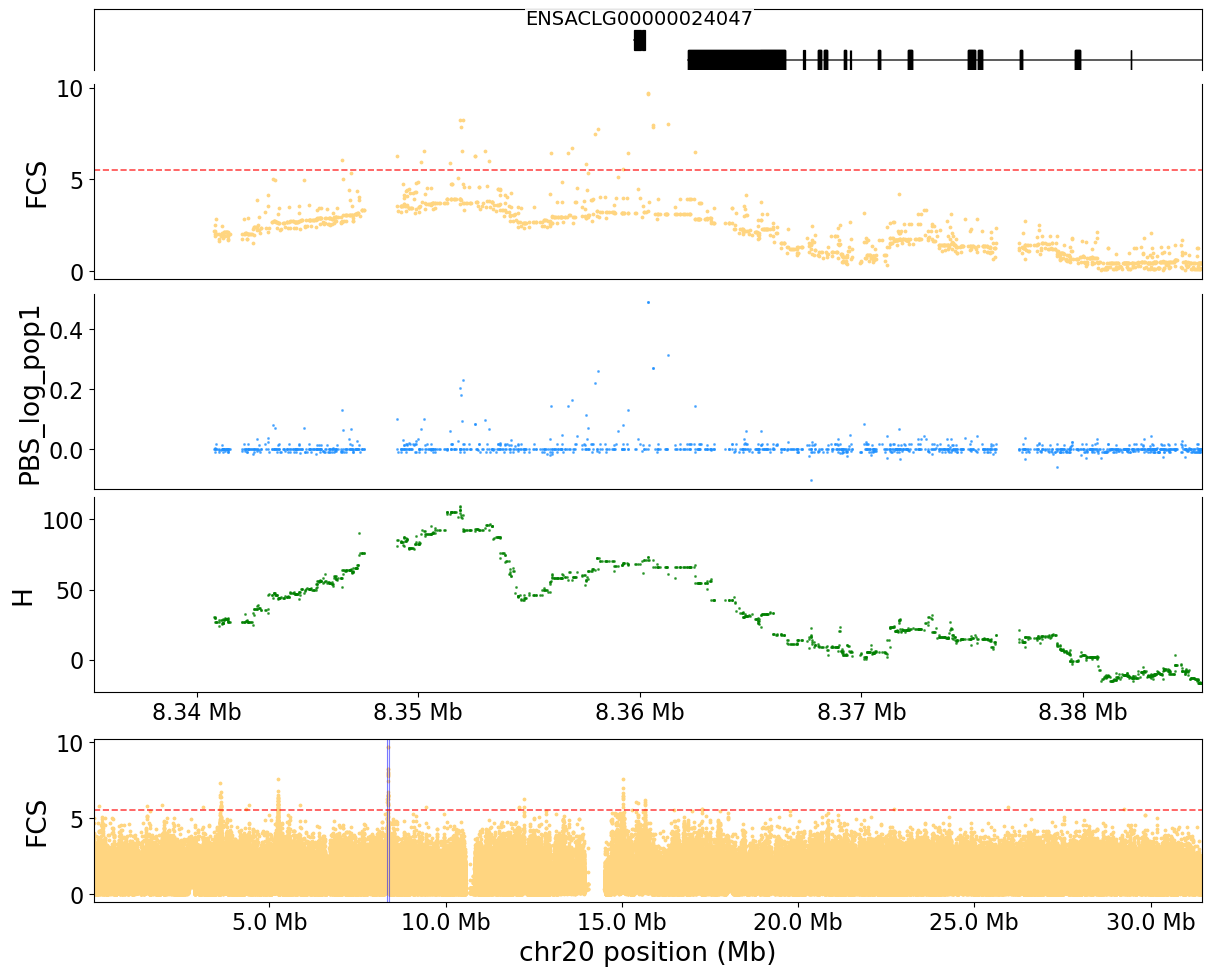

In [350]:
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr20'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr20', start=8335345, end=8385356, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

In [359]:
gene_list = ann_candidate_regions_wo_intergeneic[ann_candidate_regions_wo_intergeneic['CHROM'] == 'chr23']['ANN[*].GENE']

symbol_list_genes = []
for g in list(gene_list):
    if not g.startswith("ENSA"):
        # Already a symbol
        symbol = g.strip()
    elif g in gene_name_dict and gene_name_dict[g]:
        # Translate ENSA ID -> symbol
        symbol = gene_name_dict[g].strip()
    else:
        # Fallback: keep original
        symbol = g.strip()
    symbol_list_genes.append(symbol)

# --- Cleaning ---
# 1. Drop obvious junk
junk = {"", "CHR_START", ".", "NA", "nan", None}
cleaned = [s for s in symbol_list_genes if s not in junk]

# 2. Deduplicate while preserving order
seen = set()
unique_symbols = []
for s in cleaned:
    if s not in seen:
        seen.add(s)
        unique_symbols.append(s)

unique_symbols

['ENSACLG00000008501']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L', 'M', 'N', 'P', 'R', 'S', 'b', 'c', 'eight', 'five', 'four', 'g', 'h', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 27, 36, 37, 38, 39, 40, 41, 42, 43, 47, 48, 49, 51, 53, 54, 66, 69, 70, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87]
INFO:fontTools.subset:Close

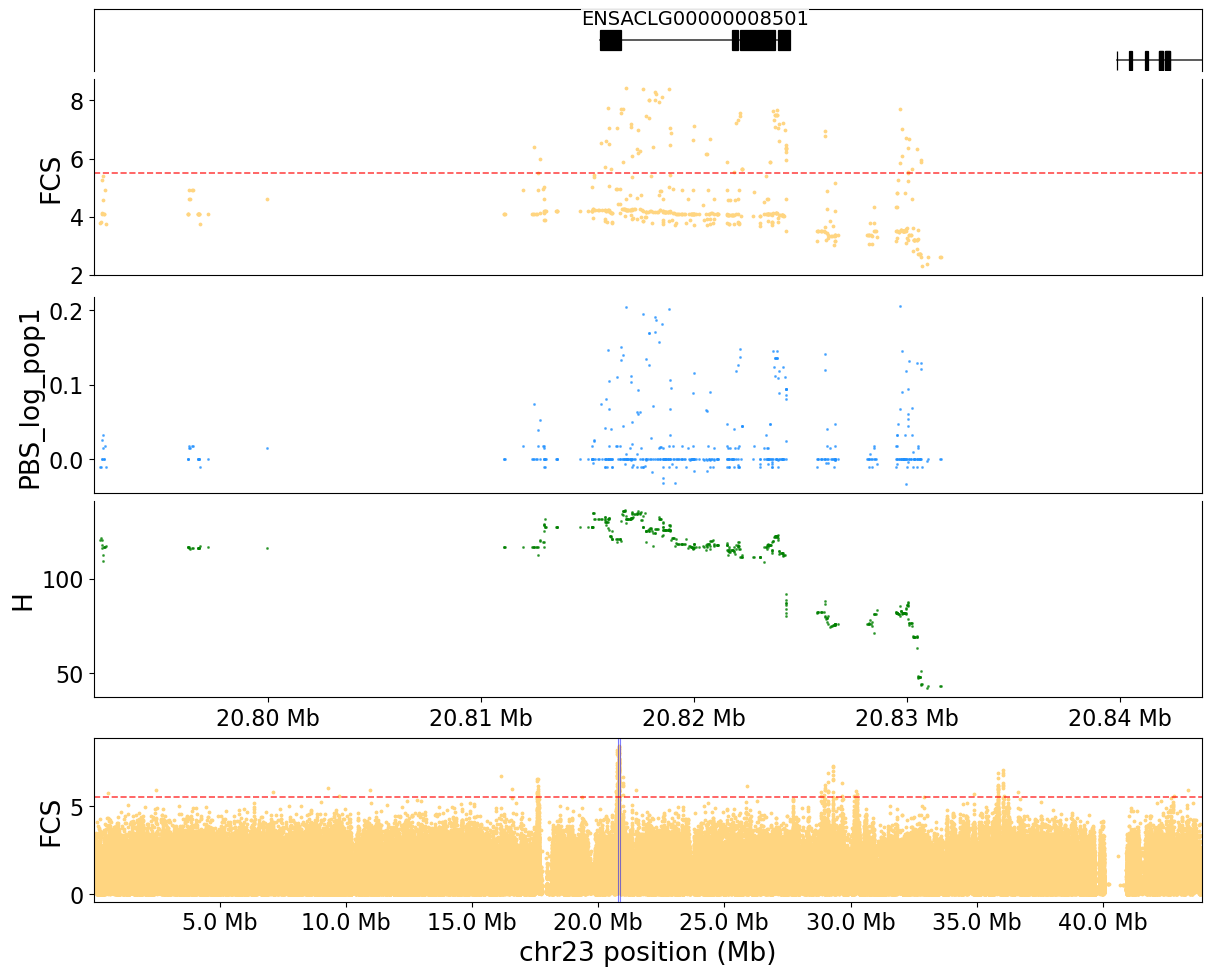

In [351]:
fig = plot_multi_zoom_overview(df = merged_H_PBS.loc['chr23'],
                             series = 'FCS', 
                             extra_series = ['PBS_log_pop1','H'],
                             extra_colors = ['dodgerblue','green'],
                             chrom='chr23', start=20791821, end=20843857, 
                             col = '#FFD580',
                             threshold = 5.512684762384413,
                             gtf_df = gtf_ensembl.to_pandas(),
                             pdf_path_base = f"{ana_dir}/Output/Figures/manhattenPlots/Zoom")

## Figure 4 / Supplementary table S5 – Intersections candidate genes

for differential expression analysis see notebook pyDeseq_Pub

In [29]:
import gtfparse
from gtfparse import read_gtf

gtf_ensembl = read_gtf(f'{ana_dir}/_data/Genomic_features/Astatotilapia_calliptera.fAstCal1.2.110_chrnames.gtf')

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_source', 'transcript_biotype', 'tag', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'gene_name', 'transcript_name', 'projection_parent_gene', 'projection_parent_transcript']


In [32]:
list_all_genes = sorted(gtf_ensembl['gene_id'].unique())
gene_name_dict = dict(zip(gtf_ensembl['gene_id'], gtf_ensembl['gene_name']))
list_all_genes_symbol = []

for i in list_all_genes:
    # print(i)
    if not i.startswith('ENSA'):
        list_all_genes_symbol.append(i)
    elif i in gene_name_dict and gene_name_dict[i] != '':
        list_all_genes_symbol.append(gene_name_dict[i])
    else:
        list_all_genes_symbol.append(i)

In [33]:
import pandas as pd
from pathlib import Path

# -----------------------------
# Inputs
# -----------------------------
candidate_files = [
    f"{ana_dir}/Output/Genomic_features/gene_list_candidate_473_clean.txt",
    f"{ana_dir}/Output/Genomic_features/gene_list_protein_changes_candidate_SNPs_clean.txt",        # additional list
]


DE_out_dir = f"{ana_dir}/Figures/DE_alex"
tissues = ["Muscle", "Gonads", "Brain", "Gills", "Liver"]
tissue_col = lambda t: f"list_genes_SigDE_candidate_{t}"

# -----------------------------
# Helpers
# -----------------------------
def read_gene_list_txt(path):
    with open(path, "r") as f:
        return [line.strip() for line in f if line.strip()]

def label_from_path(p):
    return Path(p).stem

all_genes = set(map(str, list_all_genes_symbol))
# -----------------------------
# Build empty table
# -----------------------------
candidate_cols = [label_from_path(p) for p in candidate_files]
all_cols = candidate_cols + [tissue_col(t) for t in tissues] + ["sum"]

summary_df = pd.DataFrame(index=sorted(all_genes), columns=all_cols[:-1], dtype="object")
summary_df[:] = ""  # start with blanks

# -----------------------------
# Fill candidate columns
# -----------------------------
for path, col in zip(candidate_files, candidate_cols):
    genes = set(read_gene_list_txt(path))
    summary_df.loc[summary_df.index.isin(genes), col] = "Yes"

# -----------------------------
# Fill tissue columns
# -----------------------------
for t in tissues:
    file_path = f"{DE_out_dir}/{t}/significant_DE_2.csv"
    sigs = pd.read_csv(file_path, index_col=0)
    genes = set(map(str, sigs['Symbol']))
    summary_df.loc[summary_df.index.isin(genes), tissue_col(t)] = "Yes"

# -----------------------------
# Add sum column
# -----------------------------
yes_counts = (summary_df == "Yes").sum(axis=1)
summary_df["sum"] = yes_counts

# -----------------------------
# Debug: check missing genes
# -----------------------------
cand_list = read_gene_list_txt(candidate_files[0])
cand_series = pd.Series(cand_list, name="gene")

print("Total lines in candidate file:", len(cand_list))
print("Unique after deduplication:", cand_series.nunique())

dupes = cand_series[cand_series.duplicated()].unique()
if len(dupes) > 0:
    print("⚠️ Duplicated gene symbols in candidate file:")
    for g in dupes:
        print("   ", g)

# Normalization check
normalized = {g.strip().upper() for g in cand_list}
normalized_ref = {g.strip().upper() for g in list_all_genes_symbol}
missing_after_norm = normalized - normalized_ref
print(f"Missing after normalization: {len(missing_after_norm)}")
for g in sorted(missing_after_norm)[:20]:
    print("   ", g)
# -----------------------------
# Add header row with counts
# -----------------------------
header_counts = {}
for col in summary_df.columns:
    if col == "sum":
        header_counts[col] = len(summary_df.index)
    else:
        header_counts[col] = (summary_df[col] == "Yes").sum()

header_row = pd.DataFrame(header_counts, index=[""])
final_df = pd.concat([header_row, summary_df], axis=0)

# -----------------------------
# Save
# -----------------------------
# final_df.to_csv(f"{ana_dir}/Output/Genomic_features/summary_gene_overlap_ensembl.csv")

Total lines in candidate file: 1155
Unique after deduplication: 1155
Missing after normalization: 0


### Figure 4 Upset plot

In [34]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colors as mcolors
from upsetplot import UpSet, from_indicators

def _lighten(color, amt=0.7):
    r,g,b = mcolors.to_rgb(color)
    return (r+(1-r)*amt, g+(1-g)*amt, b+(1-b)*amt)

    # Short labels & groups (your config)
SHORT = {
    'gene_list_candidate_473_clean': 'Candidates',
    'gene_list_protein_changes_candidate_SNPs_clean': 'ProtChanges',
    # 'gene_list_protein_changes_selection_snps': 'ProtChanges_selection',
    'list_genes_SigDE_candidate_Muscle': 'Muscle',
    'list_genes_SigDE_candidate_Gonads': 'Gonads',
    'list_genes_SigDE_candidate_Brain': 'Brain',
    'list_genes_SigDE_candidate_Gills': 'Gills',
    'list_genes_SigDE_candidate_Liver': 'Liver',
}
GENOME_SCAN = ['gene_list_candidate_473_clean',
               'gene_list_protein_changes_candidate_SNPs_clean']
DE_LISTS    = ['list_genes_SigDE_candidate_Muscle',
               'list_genes_SigDE_candidate_Gonads',
               'list_genes_SigDE_candidate_Brain',
               'list_genes_SigDE_candidate_Gills',
               'list_genes_SigDE_candidate_Liver']
ORDERED_COLS = GENOME_SCAN + DE_LISTS

COLOR_SCAN = "#d8b365"
COLOR_DE   = "#5ab4ac"

def plot_upset_scans_only(csv_path, min_size=1, 
                          figsize=(13.3, 5.2), base_font=16, show_counts=True, fn_out=None):
    mpl.rcParams.update({
        "font.size": base_font,
        "axes.labelsize": base_font,
        "axes.titlesize": base_font,
        "xtick.labelsize": base_font-1,
        "ytick.labelsize": base_font-1,
        "legend.fontsize": base_font-1,
    })

    # --- load & drop header summary row if present
    df = pd.read_csv(csv_path)
    first = df.iloc[0]
    if first.apply(lambda v: str(v).isdigit()).any():
        df = df.drop(index=df.index[0]).reset_index(drop=True)

    # --- booleanize and rename to SHORT
    cols = df.columns
    bool_df = df[cols].apply(lambda s: s.astype(str).str.strip().str.lower().eq("yes"))
    bool_df.columns = [SHORT.get(c, c) for c in cols]

    # which labels are present?
    scan_short = [SHORT[c] for c in GENOME_SCAN if c in cols]  # ['Candidates','ProtChanges'] if both exist
    de_short   = [SHORT[c] for c in DE_LISTS   if c in cols]

    # keep only scan rows + all DE rows
    keep_cols = [c for c in bool_df.columns if c in (scan_short + de_short)]
    bool_df = bool_df[keep_cols]

    # order rows: scans first (in given order), then DE by set size
    set_sizes = bool_df.sum(axis=0).sort_values(ascending=False)
    ordered_labels = [c for c in scan_short if c in bool_df.columns] + \
                     [lab for lab in set_sizes.index if lab in de_short]
    bool_df = bool_df[ordered_labels]

    # build intersections and filter to those including at least one scan set
    ser = from_indicators(bool_df, data=None)  # Series indexed by boolean tuples aligned to bool_df.columns
    scan_idx = [bool_df.columns.get_loc(c) for c in scan_short if c in bool_df.columns]  # positions of scan rows
    ser = ser[[any(tpl[i] for i in scan_idx) for tpl in ser.index]]  # keep if any scan=True

    # apply min_size
    if min_size and min_size > 1:
        ser = ser[ser >= min_size]

    # plot (UpSet will sort by cardinality)
    plt.figure(figsize=figsize)
    us = UpSet(
        ser,
        subset_size='count',
        show_counts=show_counts,
        min_subset_size=min_size,
        sort_categories_by=None,   # keep our row order
        sort_by="cardinality"
    )
    us.plot()

    fig = plt.gcf()
    axes = fig.get_axes()
    bars_ax   = max(axes, key=lambda ax: len(ax.patches))
    ax_catlab = max(axes, key=lambda ax: len(ax.get_yticklabels()))
    ax_matrix = max(axes, key=lambda ax: sum(hasattr(c, "get_offsets") for c in ax.collections))

    # rotate numeric labels above bars
    for t in bars_ax.texts:
        try:
            float(t.get_text())
        except ValueError:
            continue
        t.set_rotation(45)
        t.set_va("bottom")
        t.set_ha("center")

    # color row labels & shade groups
    for tick in ax_catlab.get_yticklabels():
        lab = tick.get_text()
        if lab in scan_short:
            tick.set_color(COLOR_SCAN); tick.set_fontweight("bold"); tick.set_fontsize(base_font+0.5)
        elif lab in de_short:
            tick.set_color(COLOR_DE);   tick.set_fontweight("bold"); tick.set_fontsize(base_font+0.5)

    light_DE   = _lighten(COLOR_DE,   0.7)
    light_SCAN = _lighten(COLOR_SCAN, 0.7)
    displayed  = [t.get_text() for t in ax_catlab.get_yticklabels()]
    for i, lab in enumerate(displayed):
        if lab in scan_short:
            ax_matrix.axhspan(i-0.5, i+0.5, color=light_SCAN, zorder=-1)
        elif lab in de_short:
            ax_matrix.axhspan(i-0.5, i+0.5, color=light_DE,   zorder=-1)

    # legend
    fig.legend(
        handles=[
            Patch(facecolor=COLOR_SCAN, edgecolor=COLOR_SCAN, label="Genome scans (rows)"),
            Patch(facecolor=COLOR_DE,   edgecolor=COLOR_DE,   label="RNA-seq DE (rows)"),
        ],
        loc="upper right", bbox_to_anchor=(0.98, 0.98), frameon=False
    )

    plt.tight_layout()
    if fn_out:
        plt.savefig(fn_out, bbox_inches="tight")
    plt.show()

/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermed

<Figure size 1330x520 with 0 Axes>

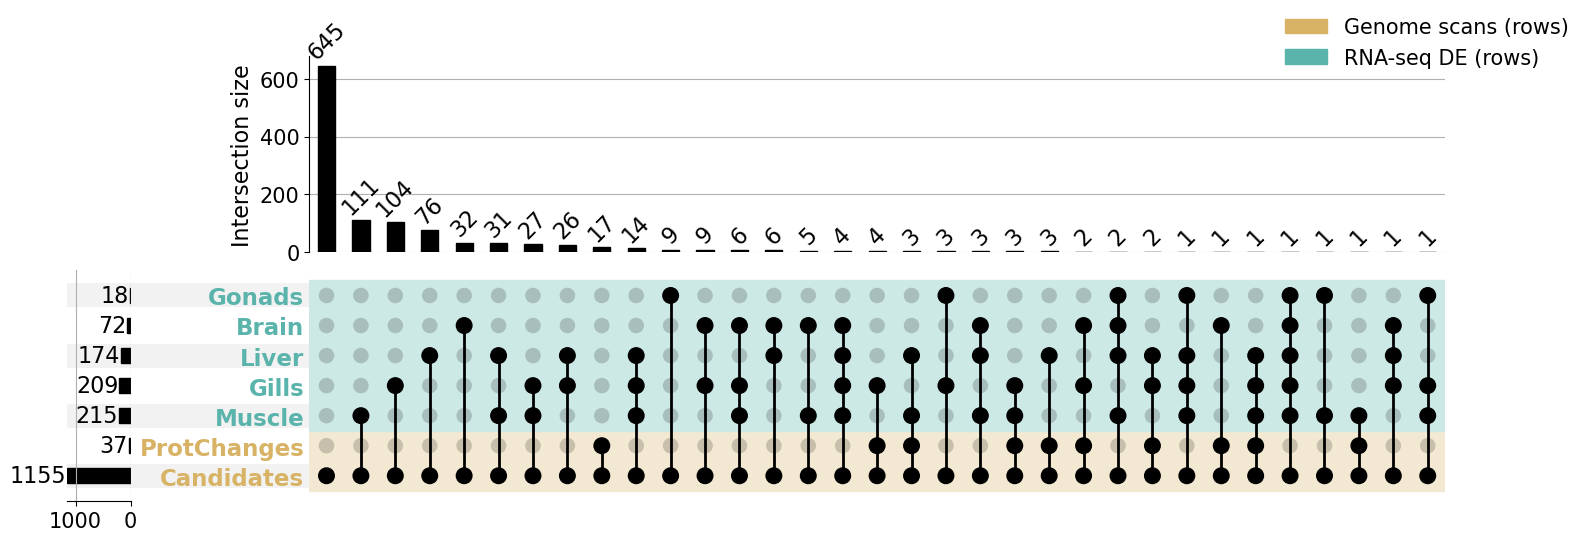

In [438]:
plot_upset_scans_only(
    f"{ana_dir}/Output/Genomic_features/summary_gene_overlap_ensembl.csv",
    min_size=1,
    figsize=(13.3, 5.2),
    base_font=16,
    show_counts=True,
    fn_out=f"{ana_dir}/Output/Figures/upset_scans_only.svg"
)

### Table 1 - significance testing Intersection 

In [35]:
import numpy as np
import pandas as pd

def perm_enrichment_scan_vs_de(
    csv_path,
    scan_cols,
    de_cols,
    strata=None,          # pd.Series indexed by gene (same index as the CSV after header drop), e.g. expression deciles; or None
    R=2000,               # number of permutations (increase to 1e4 for final results)
    random_state=0
):
    """
    Empirical enrichment of overlap (scan x DE) using permutation.
    Preserves set sizes; if `strata` is provided, also preserves the
    per-stratum composition of each DE set.

    Returns a tidy DataFrame with observed k, empirical mean/sd, fold, p-value, and CIs.
    """
    rng = np.random.default_rng(random_state)

    # --- load + booleanize ---
    df = pd.read_csv(csv_path, index_col=0)
    first = df.iloc[0].astype(str)
    if first.str.isnumeric().any():
        df = df.drop(index=df.index[0])

    df_bool = df[scan_cols + de_cols].apply(lambda s: s.astype(str).str.strip().str.lower().eq("yes"))
    df_bool.index = df.index  # make sure index is simple range or gene IDs if present
    print(len(df_bool))          
    # Optional strata checks
    if strata is not None:
        if not strata.index.equals(df_bool.index):
            print(strata)
            print(df_bool)
            raise ValueError("`strata` index must match the genes (rows) in the CSV after dropping the header row.")
        strata = strata.astype("category")
        levels = strata.cat.categories.tolist()
        # Precompute gene indices per stratum
        idx_by_stratum = {lev: np.flatnonzero(strata.values == lev) for lev in levels}
    else:
        idx_all = np.arange(df_bool.shape[0])

    # Precompute membership index sets
    idx_scan = {a: np.flatnonzero(df_bool[a].values) for a in scan_cols}
    idx_de   = {b: np.flatnonzero(df_bool[b].values) for b in de_cols}

    N = df_bool.shape[0]
    out_rows = []

    for a in scan_cols:
        A_idx = idx_scan[a]
        A = A_idx.size

        for b in de_cols:
            B_idx = idx_de[b]
            B = B_idx.size
            if A == 0 or B == 0:
                out_rows.append({
                    "scan": a, "de": b, "N": N, "A": A, "B": B,
                    "obs": 0, "null_mean": np.nan, "null_sd": np.nan,
                    "fold_vs_null": np.nan, "p_emp": np.nan,
                    "ci_lower": np.nan, "ci_upper": np.nan
                })
                continue

            # Observed overlap
            obs = np.intersect1d(A_idx, B_idx, assume_unique=False).size

            # --- permutations ---
            sim = np.empty(R, dtype=int)

            if strata is None:
                # Sample B indices without replacement from the whole universe
                for r in range(R):
                    B_samp = rng.choice(idx_all, size=B, replace=False)
                    sim[r] = np.intersect1d(A_idx, B_samp, assume_unique=False).size
            else:
                # Stratified: match the DE set's composition across strata
                # Count how many DE genes fall in each stratum
                counts = {}
                for lev, lev_idx in (idx_by_stratum.items()):
                    counts[lev] = np.intersect1d(B_idx, lev_idx, assume_unique=False).size

                # Precompute A∩stratum for fast overlaps
                A_by_stratum = {lev: np.intersect1d(A_idx, lev_idx, assume_unique=False) 
                                for lev, lev_idx in idx_by_stratum.items()}

                for r in range(R):
                    B_samp_parts = []
                    # within each stratum sample the same number as observed
                    for lev, lev_idx in idx_by_stratum.items():
                        nlev = counts[lev]
                        if nlev == 0:
                            continue
                        # if stratum smaller than needed (edge case), sample all
                        nlev = min(nlev, lev_idx.size)
                        B_samp_parts.append(rng.choice(lev_idx, size=nlev, replace=False))
                    if B_samp_parts:
                        B_samp = np.concatenate(B_samp_parts, dtype=int)
                    else:
                        B_samp = np.array([], dtype=int)

                    # intersect with A
                    sim[r] = np.intersect1d(A_idx, B_samp, assume_unique=False).size

            m = sim.mean()
            sd = sim.std(ddof=1) if R > 1 else 0.0
            # empirical one-sided p-value: P(sim >= obs)
            p_emp = (np.sum(sim >= obs) + 1) / (R + 1)  # +1 smoothing
            # fold vs empirical mean (avoid div-by-zero)
            fold_emp = (obs / m) if m > 0 else np.nan
            # 95% empirical CI
            lo, hi = (np.percentile(sim, [2.5, 97.5]) if R >= 100 else (np.nan, np.nan))

            out_rows.append({
                "scan": a, "de": b, "N": N, "A": A, "B": B,
                "obs": obs, "null_mean": m, "null_sd": sd,
                "fold_vs_null": fold_emp, "p_emp": p_emp,
                "ci_lower": lo, "ci_upper": hi
            })

    res = pd.DataFrame(out_rows)

    # Pretty labels if you have SHORT mapping
    SHORT = {
        'gene_list_candidate_473_clean': 'Candidates',
        'gene_list_protein_changes_candidate_regions_clean': 'ProtChanges',
        'list_genes_SigDE_candidate_Muscle': 'Muscle',
        'list_genes_SigDE_candidate_Gonads': 'Gonads',
        'list_genes_SigDE_candidate_Brain': 'Brain',
        'list_genes_SigDE_candidate_Gills': 'Gills',
        'list_genes_SigDE_candidate_Liver': 'Liver',
    }
    return (res
            .assign(scan=res["scan"].map(SHORT).fillna(res["scan"]),
                    de=res["de"].map(SHORT).fillna(res["de"]))
            .sort_values("p_emp"))

In [36]:
# Load per-tissue expression matrices
expr_files = {
    t: f"{DE_out_dir}/{t}/expr_matrix_DE.csv"
    for t in ["Muscle", "Gonads", "Brain", "Gills", "Liver"]
}

# Combine into global average expression table
expr_dfs = []
for tissue, path in expr_files.items():
    e = pd.read_csv(path, index_col=0)
    if e.shape[1] > e.shape[0]:
        e = e.T  # ensure genes are rows
    expr_dfs.append(e.mean(axis=1).rename(tissue))

expr_all = pd.concat(expr_dfs, axis=1)
expr_global = expr_all.mean(axis=1)

# Match to the genes in your summary CSV
df_summary = pd.read_csv(f"{ana_dir}/Output/Genomic_features/summary_gene_overlap_ensembl.csv")
genes_csv = df_summary.iloc[1:, 0] if df_summary.iloc[0].astype(str).str.isnumeric().any() else df_summary.index

# align
expr_global = expr_global.reindex(genes_csv)

# Stratify genes by global expression level (10 bins)
strata = pd.qcut(expr_global.rank(method="first"), q=10, labels=False, duplicates="drop")

In [37]:
res_emp_strat = perm_enrichment_scan_vs_de(
    csv_path=f"{ana_dir}/Output/Genomic_features/summary_gene_overlap_ensembl.csv",
    scan_cols=[
        "gene_list_candidate_473_clean",
        "gene_list_protein_changes_candidate_SNPs_clean"
    ],
    de_cols=[
        "list_genes_SigDE_candidate_Muscle",
        "list_genes_SigDE_candidate_Gonads",
        "list_genes_SigDE_candidate_Brain",
        "list_genes_SigDE_candidate_Gills",
        "list_genes_SigDE_candidate_Liver"
    ],
    strata=strata,       # ← this is the expression-decile stratification vector
    R=50000,              # number of random permutations
    random_state=42      # for reproducibility
)

26624


In [41]:
from statsmodels.stats.multitest import multipletests

# Assuming res_emp_strat is a pandas DataFrame with empirical p-values
# Replace 'P_emp' with the actual column name in your output
pvals = res_emp_strat["p_emp"].values

# Apply Benjamini–Hochberg correction
reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

# Add FDR results to your dataframe
res_emp_strat["FDR_BH"] = pvals_fdr
res_emp_strat["Significant_FDR05"] = reject

# Optional: show only significant ones
res_emp_strat_sig = res_emp_strat[res_emp_strat["Significant_FDR05"]]
res_emp_strat


scan      de      N     A     B  \
0                                      Candidates  Muscle  26624  1155  4544   
1                                      Candidates  Gonads  26624  1155   197   
2                                      Candidates   Brain  26624  1155  1428   
3                                      Candidates   Gills  26624  1155  3821   
4                                      Candidates   Liver  26624  1155  3620   
8  gene_list_protein_changes_candidate_SNPs_clean   Gills  26624    37  3821   
9  gene_list_protein_changes_candidate_SNPs_clean   Liver  26624    37  3620   
5  gene_list_protein_changes_candidate_SNPs_clean  Muscle  26624    37  4544   
7  gene_list_protein_changes_candidate_SNPs_clean   Brain  26624    37  1428   
6  gene_list_protein_changes_candidate_SNPs_clean  Gonads  26624    37   197   

   obs  null_mean   null_sd  fold_vs_null     p_emp  ci_lower  ci_upper  \
0  215   48.53296  6.048987      4.429979  0.000020      37.0      61.0   
1   18    3.80138  1.887867      4.735123  0.000020       1.0       8.0   
2   72   20.68892  4.267476      3.480124  0.000020      13.0      29.0   
3  209   59.73654  6.749477      3.498696  0.000020      47.0      73.0   
4  174   39.61910  5.595895      4.391821  0.000020      29.0      51.0   
8   12    3.17848  1.595655      3.775389  0.000020       0.0       7.0   
9    9    2.25054  1.371323      3.999040  0.000060       0.0       5.0   
5    8    2.71934  1.453263      2.941890  0.001740       0.0       6.0   
7    3    1.09318  1.006061      2.744287  0.092238       0.0       3.0   
6    0    0.20278  0.448536      0.000000  1.000000       0.0       1.0   

     FDR_BH  Significant_FDR05  
0  0.000033               True  
1  0.000033               True  
2  0.000033               True  
3  0.000033               True  
4  0.000033               True  
8  0.000033               True  
9  0.000086               True  
5  0.002175               True  
7  0.102487              False  
6  1.000000              False